# Scenario Analysis - "Grid modelling to assess electrofuels supply potential - The impact of electrofuels on the US electricity grid"

This notebook reports the results of preliminary runs for the scenarios defined in the table [here](https://docs.google.com/document/d/1ssc5ilxEhEYYjFDCo5cIAgP7zSRcO4uVUXjxbyfR88Q/edit?tab=t.0). In this notebook, a single scenario is analyzed. Another notebook is available for multi-scenario comparison.

**Scenarios Analyzed:**
- *Scenario 1: [Brief Description]*
- *Scenario 2: [Brief Description]*
- *Scenario 10: [Brief Description]*

---

## 1. Setup and Data Loading

*This section handles the initial setup, including importing necessary libraries and loading the solved PyPSA network data for each scenario.*

### 1.1. Import Libraries

In [1]:
!pip install plotly -qq

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pycountry

import pypsa
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
from pathlib import Path

import cartopy.crs as ccrs # For plotting maps
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import box
from matplotlib.offsetbox import AnnotationBbox, AuxTransformBox
from matplotlib.patches import Wedge
import matplotlib.path as mpath
import matplotlib.transforms as mtransforms
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerPatch
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.font_manager import FontProperties

import plotly.express as px
import plotly.graph_objects as go

from shapely.geometry import LineString
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import yaml

import warnings
warnings.filterwarnings("ignore")

from _helpers import (
    attach_grid_region_to_buses, attach_state_to_buses, compute_demand,
    compute_data_center_load, compute_carrier_costs, fill_missing_color,
    fill_missing_nice_names, update_ac_dc_bus_coordinates, assign_location,
    create_hydrogen_capacity_map, print_hydrogen_capacity_summary, create_ft_capacity_by_grid_region_map,
    create_ft_capacity_map, compute_h2_capacities, plot_h2_capacities_bar, calculate_dispatch, 
    plot_electricity_dispatch, compute_and_plot_load, calculate_lcoe_summary_and_map,
    plot_lcoe_map_by_grid_region, plot_h2_capacities_map, plot_lcoh_maps_by_grid_region,
    calculate_weighted_lcoh_table_by_year, calculate_total_generation_by_carrier,
    plot_hydrogen_dispatch, analyze_fischer_tropsch_costs_by_region,
    compute_aviation_fuel_demand
    )

/home/user/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.width', None)    
pd.set_option('display.max_colwidth', None)

### 1.2. Load Solved Network(s)

Scenario 1 is used as default for the analysis. Please change the number in `scenario_dir` to analyze a different scenario. The base year results are common for all the scenarios.

In [4]:
# -----------------------------
# Project folder path
# -----------------------------
project_root = Path().resolve()

# -----------------------------
# Base year network path
# -----------------------------
base_year_file = project_root / "results" / "base_year" / "elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc"

networks = {
    "Base_2023": pypsa.Network(base_year_file)
}

# -----------------------------
# Scenario folder path (single scenario)
# -----------------------------
scenario_dir = project_root / "results" / "scenarios" / "scenario_02" #change the number to choose the scenario of your interest

## Folder structure
#  project_root/
#  └── notebooks/
#       ├── scenario_analysis.ipynb
#       └── results/
#            ├── base_year/
#            │   ├── elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc
#            └── scenarios/
#                 ├── scenario_01/
#                 │   ├── elec_s_100_ec_lcopt_3H_3H_2030_0.071_AB_10export.nc
#                 │   ├── elec_s_100_ec_lcopt_3H_3H_2035_0.071_AB_10export.nc
#                 │   └── elec_s_100_ec_lcopt_3H_3H_2040_0.071_AB_10export.nc
#                 ├── scenario_02/
#                 ├── ...
#                 ├── scenario_10/

years = [2030, 2035, 2040]

# -----------------------------
# Upload available networks per year
# -----------------------------
for year in years:
    file_name = f"elec_s_100_ec_lcopt_3H_3H_{year}_0.071_AB_10export.nc"
    file_path = scenario_dir / file_name

    if file_path.exists():
        scenario_name = scenario_dir.name  # e.g., "scenario_01"
        key = f"{scenario_name}_{year}"
        networks[key] = pypsa.Network(file_path)
        print(f"Loaded: {key}")
    else:
        print(f"Missing: {file_path.relative_to(project_root)}")

network_names = list(networks.keys())
print("\n Uploaded networks:")
print(list(networks.keys()))

INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H_3H_2030_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


Loaded: scenario_02_2030


INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H_3H_2035_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


Loaded: scenario_02_2035


INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H_3H_2040_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


Loaded: scenario_02_2040

 Uploaded networks:
['Base_2023', 'scenario_02_2030', 'scenario_02_2035', 'scenario_02_2040']


In [5]:
grid_region_shapes_path = project_root / "needs_grid_regions_aggregated.geojson"
state_shapes_path = project_root / "gadm41_USA_1.json"

regions_onshore = gpd.read_file(grid_region_shapes_path)

In [6]:
with open('plotting.yaml', 'r') as file:
    plotting = yaml.safe_load(file)

tech_colors = plotting['tech_colors']
nice_names = plotting['nice_names']
rename_techs = plotting['rename_tech']
rename_tech_colors = plotting['renamed_tech_colors']

In [7]:
for network in networks.keys():
    attach_grid_region_to_buses(networks[network], grid_region_shapes_path)
    attach_state_to_buses(networks[network], state_shapes_path)

---

## 2. Input Data Analysis & Validation

*Before diving into results, we validate and visualize the key input data that drives the model. This primarily focuses on electricity demand.*

### 2.1. Demand Projections & Overview
*A summary of the overall demand assumptions for the model years.*

In [8]:
# Code to extract and display demand assumptions
# e.g., total annual TWh demand per country
pass

### 2.2. Country-wise Total Electricity Demand (Time Series)
*This plot shows the electricity demand profile over the year for each country, which is a primary driver for the system's operation.*

In [9]:
networks.keys()

dict_keys(['Base_2023', 'scenario_02_2030', 'scenario_02_2035', 'scenario_02_2040'])

In [10]:
# Industrial processes consuming AC electricity
target_processes = [
    "SMR CC", "Haber-Bosch", "ethanol from starch", "ethanol from starch CC",
    "DRI", "DRI CC", "DRI H2", "BF-BOF", "BF-BOF CC", "EAF",
    "dry clinker", "cement finishing", "dry clinker CC"
]

# Static and dynamic loads
static_load_carriers = ["rail transport electricity", "agriculture electricity", "industry electricity"]
dynamic_load_carriers = ["AC", "services electricity", "land transport EV", "data center"]

demand = pd.DataFrame(columns=networks.keys(),
                      index=dynamic_load_carriers + static_load_carriers + ["total demand"])
demand.index.name = "Load type (TWh)"

for name, n in networks.items():
    nhours = n.snapshot_weightings.objective.sum()

    # 1. Static loads
    static_totals = (
        n.loads.groupby("carrier").sum().p_set
        .reindex(static_load_carriers)
        .fillna(0)
    )
    static_load_twh = static_totals.sum() * nhours / 1e6

    # 2. Industrial AC
    process_links = n.links[n.links.carrier.isin(target_processes)]
    ac_input_links = process_links[process_links.bus0.map(n.buses.carrier) == "AC"].index
    ind_ac_profile = n.links_t.p0[ac_input_links].sum(axis=1)
    ind_ac_twh = (ind_ac_profile * n.snapshot_weightings.objective).sum() / 1e6

    # 3. Non-industrial AC
    ac_loads = n.loads[n.loads.carrier == "AC"]
    industrial_ac_buses = n.links.loc[ac_input_links, "bus0"].unique()
    ac_non_ind_idx = ac_loads[~ac_loads.bus.isin(industrial_ac_buses)].index
    ac_profile = n.loads_t.p_set[ac_non_ind_idx.intersection(n.loads_t.p_set.columns)].sum(axis=1)
    ac_twh = (ac_profile * n.snapshot_weightings.objective).sum() / 1e6 - ind_ac_twh

    # 4. Services and EVs
    serv_idx = [i for i in n.loads[n.loads.carrier == "services electricity"].index
                if i in n.loads_t.p_set.columns]
    ev_idx = [i for i in n.loads[n.loads.carrier == "land transport EV"].index
              if i in n.loads_t.p_set.columns]
    serv_profile = n.loads_t.p_set[serv_idx].sum(axis=1) if serv_idx else 0
    ev_profile = n.loads_t.p_set[ev_idx].sum(axis=1) if ev_idx else 0
    serv_twh = (serv_profile * n.snapshot_weightings.objective).sum() / 1e6
    ev_twh = (ev_profile * n.snapshot_weightings.objective).sum() / 1e6

    # 5. Data centers
    data_center_p_set_sum = n.loads.loc[n.loads.carrier == "data center", "p_set"].sum()
    data_center_twh = data_center_p_set_sum * nhours / 1e6

    # 6. Other electricity (included in industrial consumption)
    other_idx = [i for i in n.loads[n.loads.carrier == "other electricity"].index
                 if i in n.loads_t.p_set.columns]
    other_profile = n.loads_t.p_set[other_idx].sum(axis=1) if other_idx else 0
    other_twh = (other_profile * n.snapshot_weightings.objective).sum() / 1e6

    industry_static_twh = static_totals.get("industry electricity", 0) * nhours / 1e6
    industry_elec_twh = industry_static_twh + ind_ac_twh + other_twh

    demand.loc["rail transport electricity", name] = static_totals.get("rail transport electricity", 0) * nhours / 1e6
    demand.loc["agriculture electricity", name] = static_totals.get("agriculture electricity", 0) * nhours / 1e6
    demand.loc["industry electricity", name] = industry_elec_twh
    demand.loc["AC", name] = ac_twh
    demand.loc["services electricity", name] = serv_twh
    demand.loc["land transport EV", name] = ev_twh
    demand.loc["data center", name] = data_center_twh
    demand.loc["total demand", name] = (
        static_load_twh + ac_twh + ind_ac_twh + serv_twh + ev_twh + data_center_twh + other_twh
    )
    demand.loc["total demand no data center", name] = (
        static_load_twh + ac_twh + ind_ac_twh + serv_twh + ev_twh + other_twh
    )


In [11]:
# === 1. NREL reference values (2023, 2030, 2040) ===
nrel_data = {
    "AC (residential + some industrial processes)": [1360.81, 1359.91, 1392.19],
    "services electricity": [1381.11, 1398.69, 1579.71],
    "land transport EV":    [13.10,   73.95,   59.70],
    "rail transport electricity": [7.29, 7.64, 8.29],
    "agriculture electricity": [np.nan, np.nan, np.nan],
    "industry electricity": [1036.81, 1109.69, 1213.94],
    "data center": [np.nan, np.nan, np.nan],
    "total demand (incl. data centers)": [3799.12, 4293.30, 5072.86],
    "total demand (excl. data centers)": [3799.12, 4293.30, 5072.86],
}

# 2. Mapping PyPSA names → NREL names
row_rename_map = {
    "AC": "AC (residential + some industrial processes)",
    "total demand": "total demand (incl. data centers)",
    "total demand no data center": "total demand (excl. data centers)"
}

# 3. Extract years from network names
network_years = {}
for key in networks:
    match = re.search(r'(\d{4})', key)
    if match:
        network_years[int(match.group(1))] = key

rows = list(nrel_data.keys())
columns = pd.MultiIndex.from_product(
    [sorted(network_years.keys()), ["PyPSA-Earth", "NREL", "diff %"]]
)
comparison_df = pd.DataFrame(index=rows, columns=columns)

for year, net_key in network_years.items():
    for row in rows:
        pypsa_row = {v: k for k, v in row_rename_map.items()}.get(row, row)
        
        pypsa_val = demand.at[pypsa_row, net_key] if pypsa_row in demand.index else np.nan
        nrel_vals = nrel_data.get(row, None)

        if nrel_vals and year in [2023, 2030, 2040]:
            col_idx = [2023, 2030, 2040].index(year)
            nrel_val = nrel_vals[col_idx]
        else:
            nrel_val = np.nan

        comparison_df.at[row, (year, "PyPSA-Earth")] = pypsa_val
        comparison_df.at[row, (year, "NREL")] = nrel_val

        if pd.notna(pypsa_val) and pd.notna(nrel_val) and nrel_val != 0:
            diff = 100 * (pypsa_val - nrel_val) / nrel_val
        else:
            diff = np.nan
        comparison_df.at[row, (year, "diff %")] = diff

def highlight_diff(val):
    if pd.isna(val):
        return ''
    if val > 10:
        return 'background-color: #ffcccc'  # light red
    elif val < -10:
        return 'background-color: #cce5ff'  # sky blue
    else:
        return 'background-color: #d4edda'  # light green

styled = comparison_df.style
for year in network_years:
    styled = styled.applymap(highlight_diff, subset=pd.IndexSlice[:, (year, "diff %")])
styled = styled.format(na_rep="N/A", precision=2)

display(styled)


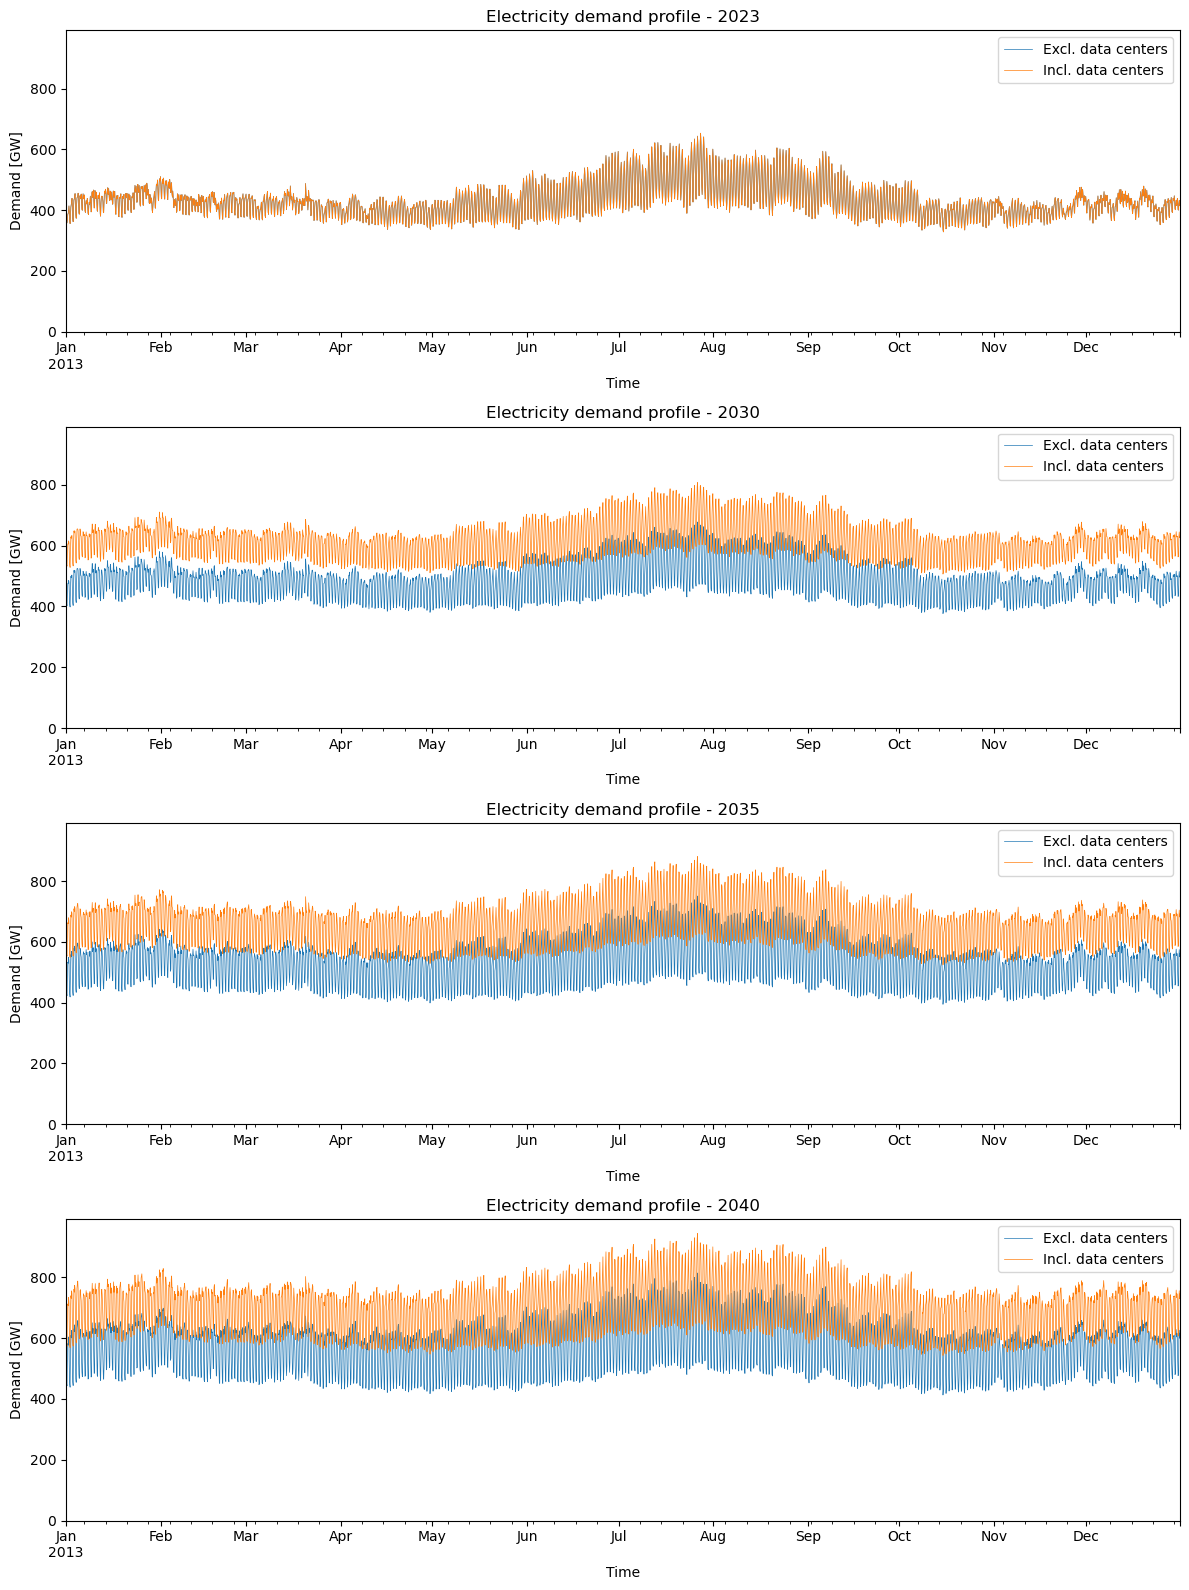

In [12]:
# === 1. Extract years from network names ===
years = {}
for name in networks:
    match = re.search(r"\d{4}", name)
    if match:
        years[int(match.group())] = name
years = dict(sorted(years.items()))  # sort by year

# === 2. Compute y-axis max (in GW) and build demand profiles ===
y_max = 0
demand_profiles_incl = {}
demand_profiles_excl = {}

for year, name in years.items():
    n = networks[name]
    nhours = n.snapshot_weightings.objective.sum()

    # Dynamic loads: AC, services, EV, other electricity
    dynamic_loads = n.loads[n.loads.carrier.isin(["AC", "services electricity", "land transport EV", "other electricity"])]
    dynamic_idx = dynamic_loads.index.intersection(n.loads_t.p_set.columns)
    dyn_profile = n.loads_t.p_set[dynamic_idx].sum(axis=1)

    # Static loads: rail, agriculture, industry
    static_carriers = ["rail transport electricity", "agriculture electricity", "industry electricity"]
    static_load = n.loads[n.loads.carrier.isin(static_carriers)]
    static_sum = static_load.groupby("carrier").sum()["p_set"].sum()  # MW
    static_profile = pd.Series(static_sum, index=n.snapshots)

    # Data centers (flat profile if present)
    if "data center" in n.loads.carrier.values:
        dc_sum = n.loads[n.loads.carrier == "data center"]["p_set"].sum()
        dc_profile = pd.Series(dc_sum, index=n.snapshots)
    else:
        dc_profile = 0

    # Total profiles (in GW)
    profile_excl = (dyn_profile + static_profile) / 1000
    profile_incl = (dyn_profile + static_profile + dc_profile) / 1000

    demand_profiles_excl[year] = profile_excl
    demand_profiles_incl[year] = profile_incl

    y_max = max(y_max, profile_incl.max())

y_max *= 1.05  # add 5% margin

# === 3. Plot profiles for each year ===
fig, axes = plt.subplots(nrows=len(years), figsize=(12, 4 * len(years)), sharey=True)

if len(years) == 1:
    axes = [axes]  # ensure list if only one subplot

for ax, (year, name) in zip(axes, years.items()):
    demand_profiles_excl[year].plot(ax=ax, linewidth=0.5, color="tab:blue", label="Excl. data centers")
    demand_profiles_incl[year].plot(ax=ax, linewidth=0.5, color="tab:orange", label="Incl. data centers")

    ax.set_title(f"Electricity demand profile - {year}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Demand [GW]")
    ax.set_ylim(0, y_max)
    ax.legend(loc="upper right")

plt.tight_layout()
plt.show()


### 2.3. State-wise Total Electricity Demand (Validation Year)
*A bar plot showing the total annual electricity demand for each state or region for the validation year. This helps confirm the spatial distribution of demand.*

In [13]:
base_demand_grid_region, base_demand_state = compute_demand(networks["Base_2023"])

In [14]:
base_demand_grid_region.T

region                      Alaska  California  Delta  Florida  Hawaii  \
carrier                                                                  
AC                            0.79       93.45  62.43    86.00    3.21   
agriculture electricity       0.06        5.55   1.62     2.17    0.25   
industry electricity          1.10       69.15  38.91    17.47    3.36   
land transport EV             0.08        6.66   1.90     2.49    0.29   
rail transport electricity    0.01        0.54   0.16     0.21    0.02   
services electricity          0.71       85.03  56.79    78.25    2.92   

region                      Mid-Atlantic  Midwest  Mountain  New England  \
carrier                                                                    
AC                                294.25   175.19     49.63        31.86   
agriculture electricity            10.13     7.09      3.56         1.76   
industry electricity              153.96    88.76     36.51        26.10   
land transport EV                  12.41     8.81      4.44         2.20   
rail transport electricity          0.97     0.69      0.34         0.17   
services electricity              267.71   159.39     45.15        28.98   

region                      New York  Northwest  Plains  Southeast  Southwest  \
carrier                                                                         
AC                             68.20      64.13  112.19     224.31      56.55   
agriculture electricity         4.36       2.50    3.98       8.33       2.30   
industry electricity           67.34      26.61   48.15      77.29      18.16   
land transport EV               5.42       3.11    4.83       9.86       2.75   
rail transport electricity      0.43       0.24    0.40       0.80       0.23   
services electricity           62.05      58.34  102.08     204.06      51.45   

region                       Texas  
carrier                             
AC                          149.50  
agriculture electricity       3.64  
industry electricity         59.59  
land transport EV             4.25  
rail transport electricity    0.35  
services electricity        136.01

In [15]:
base_demand_state.T

region                        AK     AL     AR     AZ      CA     CO     FL  \
carrier                                                                       
AC                          0.79  30.60  11.03  31.64  100.66  23.92  90.43   
agriculture electricity     0.06   0.70   0.22   0.99    7.12   1.38   3.06   
industry electricity        1.10   9.75   2.40   6.68   84.92  12.93  24.83   
land transport EV           0.08   0.82   0.26   1.17    8.60   1.72   3.53   
rail transport electricity  0.01   0.07   0.02   0.10    0.69   0.13   0.30   
services electricity        0.71  27.84  10.03  28.79   91.59  21.77  82.28   

region                         GA    HI     IA     ID     IL     IN     KS  \
carrier                                                                      
AC                          64.14  3.21  27.06  14.73  44.61  16.33  11.91   
agriculture electricity      2.46  0.25   0.91   1.09   1.61   0.65   0.59   
industry electricity        19.77  3.36  11.01   8.79  23.72   6.71   8.62   
land transport EV            2.90  0.29   1.12   1.36   1.98   0.79   0.71   
rail transport electricity   0.23  0.02   0.09   0.10   0.16   0.06   0.06   
services electricity        58.35  2.92  24.62  13.40  40.59  14.86  10.84   

region                         KY     LA     MA     MD    ME     MI     MN  \
carrier                                                                      
AC                          25.73  42.05  27.68  34.03  4.18  50.51  24.26   
agriculture electricity      1.03   1.14   1.51   1.37  0.25   1.47   0.77   
industry electricity        13.41  33.39  22.85  20.86  3.18  16.83  11.53   
land transport EV            1.26   1.33   1.87   1.66  0.32   1.84   0.97   
rail transport electricity   0.10   0.11   0.15   0.13  0.02   0.14   0.08   
services electricity        23.41  38.26  25.18  30.96  3.80  45.94  22.07   

region                         MO    MS    MT     NC     ND     NE    NH  \
carrier                                                                    
AC                          31.82  9.35  5.27  47.59  11.81  19.60  0.00   
agriculture electricity      1.15  0.26  0.17   1.52   0.31   0.74  0.00   
industry electricity        15.12  3.12  2.63  13.06   4.26   9.41  0.07   
land transport EV            1.39  0.31  0.21   1.81   0.39   0.97  0.01   
rail transport electricity   0.11  0.03  0.02   0.14   0.04   0.07  0.00   
services electricity        28.96  8.50  4.79  43.29  10.75  17.83  0.00   

region                         NM     NV     NY     OH     OK     OR     PA  \
carrier                                                                       
AC                          17.63  11.61  68.20  60.49  31.07  15.80  82.08   
agriculture electricity      0.98   0.93   4.36   2.14   0.56   0.31   3.65   
industry electricity         9.28   7.61  67.34  28.56   8.45   3.05  62.33   
land transport EV            1.16   1.13   5.42   2.62   0.66   0.39   4.48   
rail transport electricity   0.10   0.09   0.43   0.20   0.06   0.03   0.35   
services electricity        16.04  10.56  62.05  55.04  28.27  14.38  74.67   

region                         SC    SD     TN      TX     UT     VA     WA  \
carrier                                                                       
AC                          30.88  3.34  46.67  173.38  11.57  40.06  29.09   
agriculture electricity      1.11  0.17   1.65    4.39   0.35   0.94   1.01   
industry electricity         9.29  2.08  18.06   67.37   3.25  11.06  13.95   
land transport EV            1.31  0.22   1.98    5.14   0.44   1.14   1.25   
rail transport electricity   0.11  0.02   0.16    0.42   0.03   0.09   0.10   
services electricity        28.09  3.04  42.46  157.73  10.52  36.45  26.46   

region                         WI     WV    WY  
carrier                                         
AC                          27.56  12.66  4.66  
agriculture electricity      1.41   0.48  0.08  
industry electricity        16.03   8.96  1.48

In [16]:
fig1 = px.bar(base_demand_grid_region, barmode='stack', text_auto='.1f')
fig1.update_layout(width=1100, yaxis_title='Demand (TWh)', xaxis_title='Grid region', title='Electricity demand by type of load and Grid region (2023)')
fig1.show()

fig1 = px.bar(base_demand_state, barmode='stack', text_auto='.1f')
fig1.update_layout(width=3000, yaxis_title='Demand (TWh)', xaxis_title='State', title='Electricity Demand by type of load and State (2023)')
fig1.show()

### 2.4. Data Center Loads/Demands
*Isolating and visualizing the specific demand profile of data centers to understand their impact on the system.*

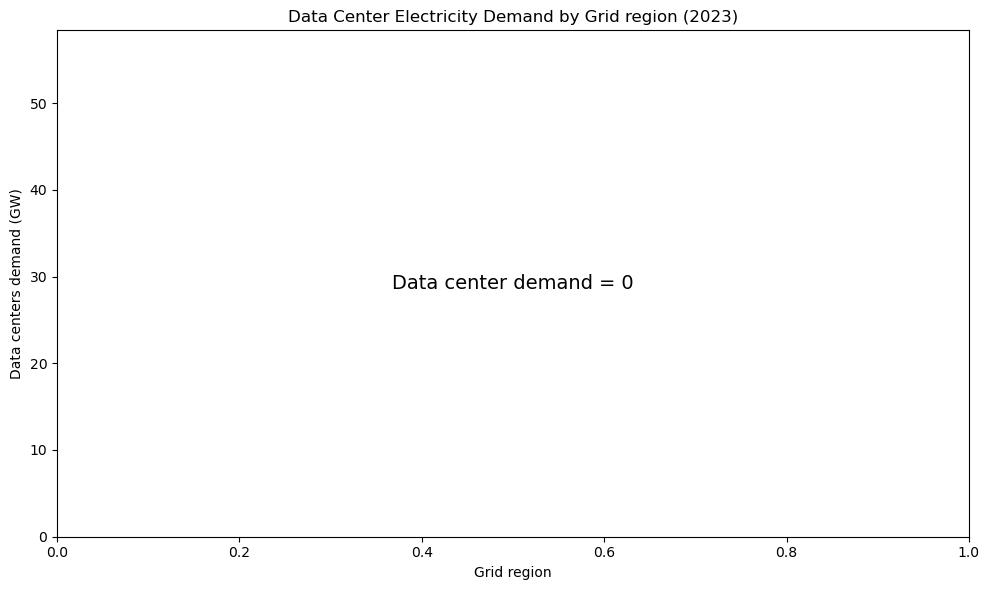

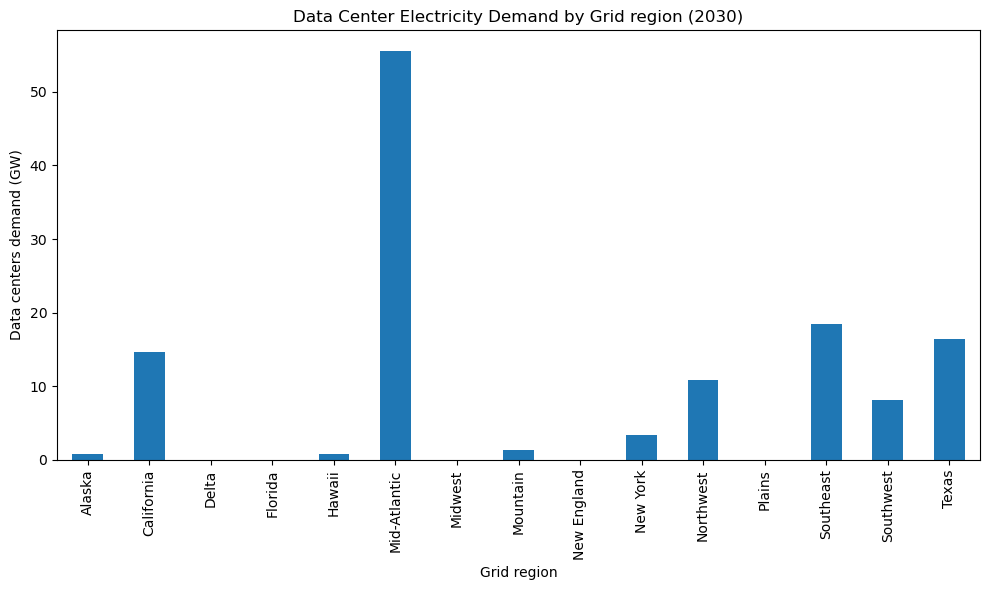

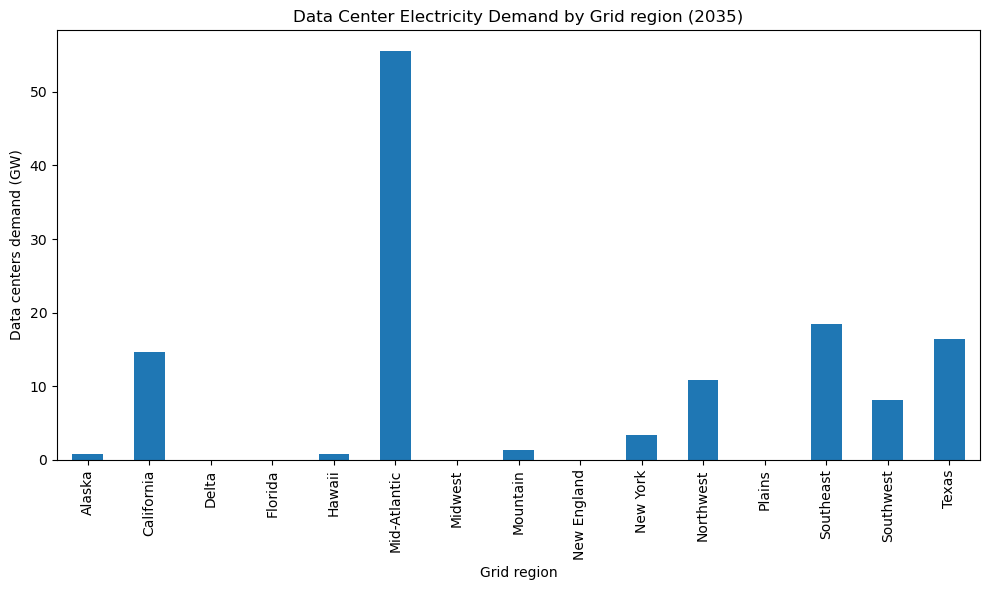

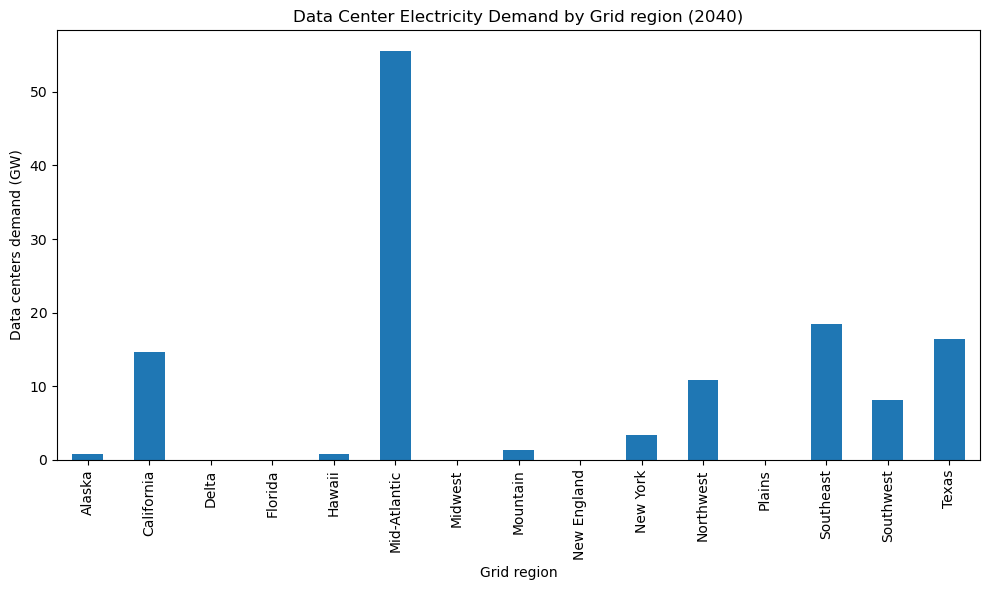

In [17]:
data_center_load = {}
for key, net in networks.items():
    data_center_load[key] = compute_data_center_load(net)

max_val = 0
for df in data_center_load.values():
    demand_by_grid_region = df.groupby("grid_region")["p_set"].sum().div(1e3)
    if not demand_by_grid_region.empty:
        max_val = max(max_val, demand_by_grid_region.max())

ymax = max(max_val * 1.05, 1)

for key, df in data_center_load.items():
    demand_by_grid_region = df.groupby("grid_region")["p_set"].sum().div(1e3)

    year_match = re.search(r"\d{4}", key)
    year = year_match.group() if year_match else "Unknown Year"

    if demand_by_grid_region.empty:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.set_title(f"Data Center Electricity Demand by Grid region ({year})")
        ax.set_ylabel("Data centers demand (GW)")
        ax.set_xlabel("Grid region")
        ax.set_ylim(0, ymax)
        ax.text(0.5, 0.5, 'Data center demand = 0', ha='center', va='center', fontsize=14, transform=ax.transAxes)
        plt.tight_layout()
        plt.show()
        continue

    ax = demand_by_grid_region.plot(
        kind="bar",
        title=f"Data Center Electricity Demand by Grid region ({year})",
        ylabel="Data centers demand (GW)",
        xlabel="Grid region",
        figsize=(10, 6),
        legend=False
    )
    ax.set_ylim(0, ymax)
    plt.tight_layout()
    plt.show()

No demand data for Base_2023


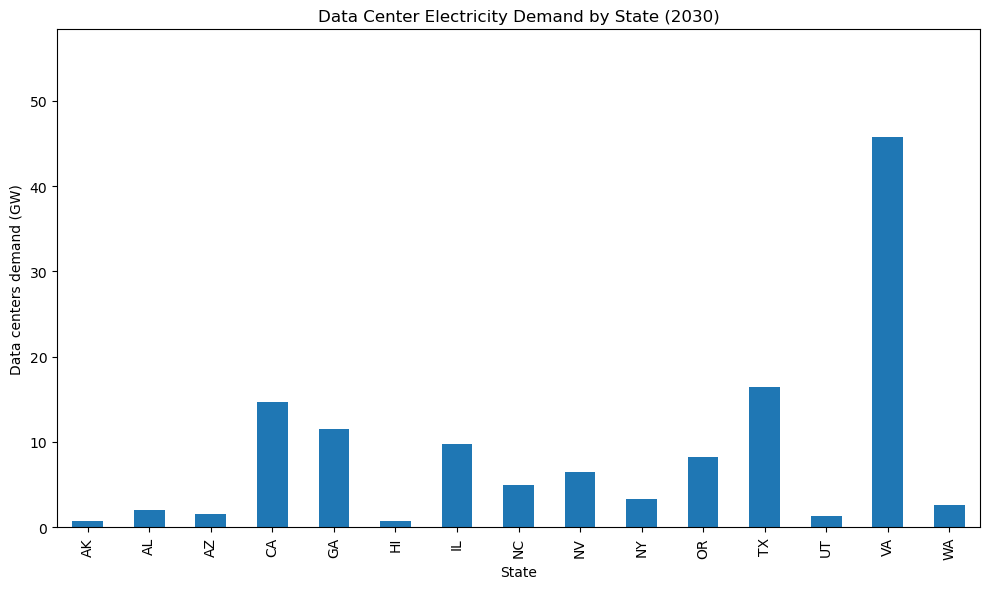

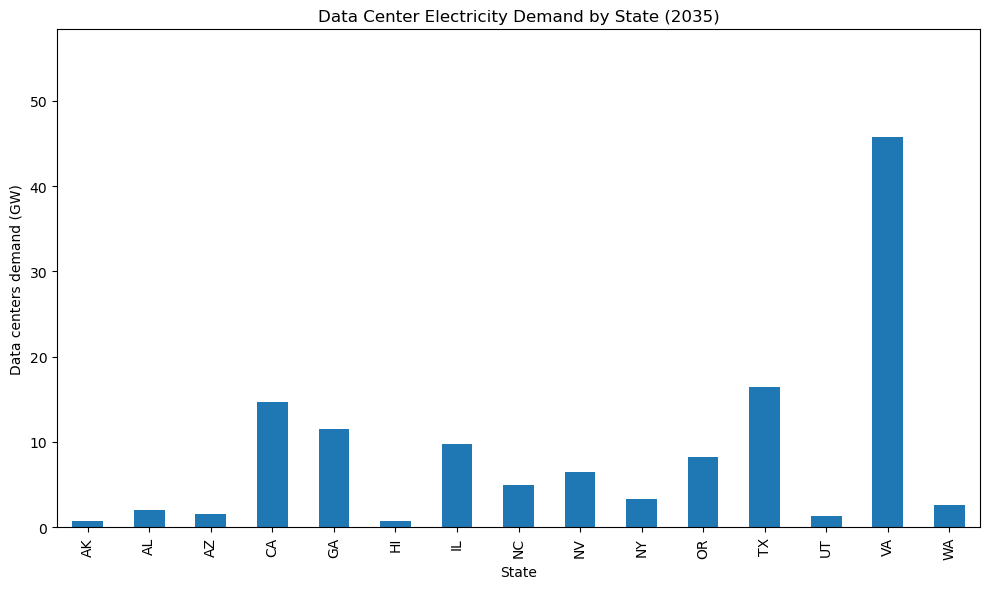

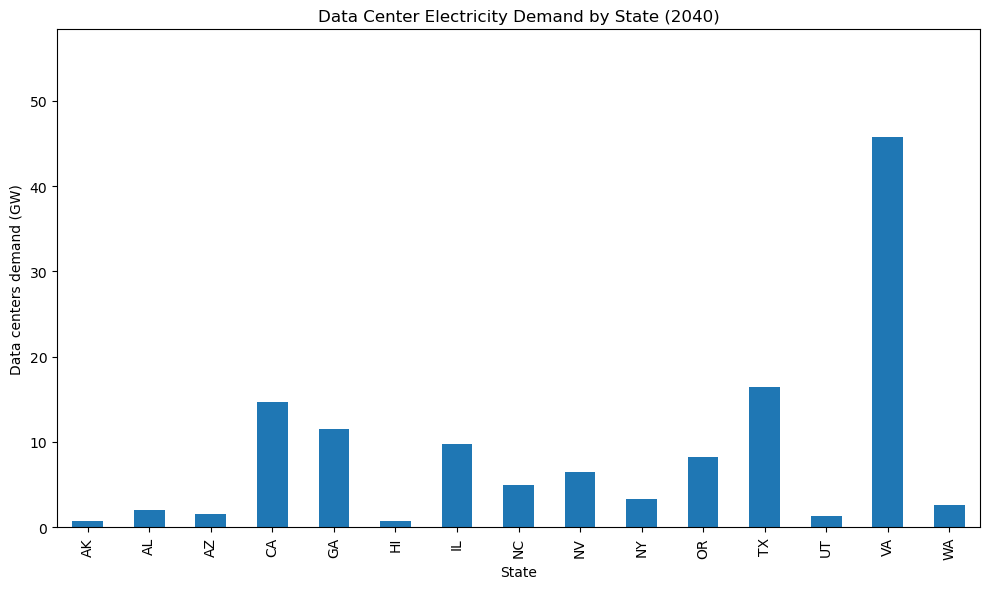

In [18]:
for key, df in data_center_load.items():
    demand_by_state = df.groupby("state")["p_set"].sum().div(1e3)
    demand_by_state = demand_by_state[demand_by_state > 0]

    if demand_by_state.empty:
        print(f"No demand data for {key}")
        continue

    # Extract year from key assuming format like "scenario_01_2030"
    year_match = re.search(r"\d{4}", key)
    year = year_match.group() if year_match else "Unknown Year"

    ax = demand_by_state.plot(
        kind="bar",
        title=f"Data Center Electricity Demand by State ({year})",
        ylabel="Data centers demand (GW)",
        xlabel="State",
        figsize=(10, 6),
        legend=False
    )
    ax.set_ylim(0, max_val * 1.05)
    plt.tight_layout()
    plt.show()

## 3. High-Level Results: System Cost

*This section presents the primary objective function result: the total annualized system cost.*

### 3.1. Total System Cost per Scenario
*A comparison of the total system cost across all analyzed scenarios. This is the key metric for overall economic performance.*

In [19]:
for idx, network in enumerate(networks.keys()):
    carrier_costs = compute_carrier_costs(networks[network], rename_techs).rename(columns={"cost": network_names[idx]}) / 1e9
    if idx == 0:
        total_carrier_costs = carrier_costs
    else:
        total_carrier_costs = total_carrier_costs.join(carrier_costs, how='outer', rsuffix=f'_{idx}')

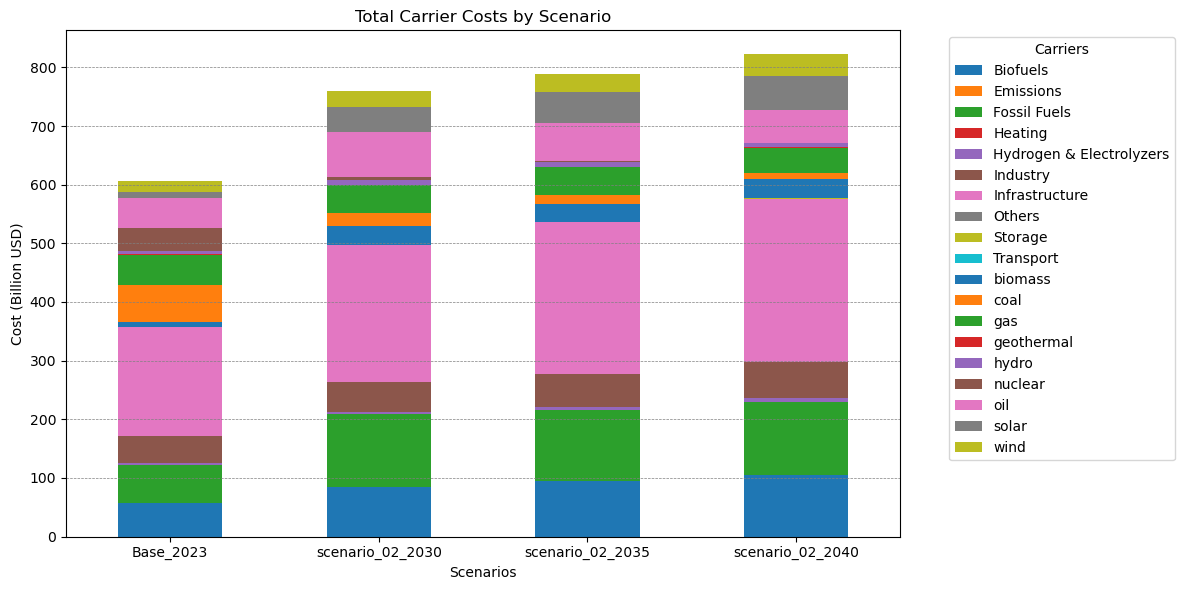

In [20]:
total_carrier_costs.T.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Total Carrier Costs by Scenario")
plt.ylabel("Cost (Billion USD)")
plt.xlabel("Scenarios")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
plt.legend(title="Carriers", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

---

## 4. Capacity Analysis: What Was Built?

*Here, we analyze the optimal installed capacities of generation, storage, and conversion technologies as determined by the model.*

### 4.1. Map: Total Installed Electricity Capacity
*A map showing the total installed capacity (in GW) for each electricity generation carrier (e.g., Solar, Onshore Wind, Offshore Wind) at different locations.*

In [21]:
regions_onshore = gpd.read_file(grid_region_shapes_path)

# Prepare Data for Plotting
gen_p_nom_opt = n.generators.groupby(["bus", "carrier"]).p_nom_opt.sum()
sto_p_nom_opt = n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum()
bus_carrier_capacity = pd.concat([gen_p_nom_opt, sto_p_nom_opt])
bus_carrier_capacity = bus_carrier_capacity[bus_carrier_capacity > 0]

line_values = n.lines.s_nom
links_values = n.links[n.links.carrier == "DC"].p_nom

n = update_ac_dc_bus_coordinates(n)

# Find carriers that need a color
carriers_to_plot = bus_carrier_capacity.index.get_level_values(1).unique()
for carrier in carriers_to_plot:
    if carrier not in n.carriers.index:
        n.add("Carrier", carrier)

for idx in tech_colors.keys():
    n.carriers.loc[idx, "color"] = tech_colors[idx]
    
fill_missing_nice_names(n, nice_names)

# Assign colors from the dictionary, using 'gray' for any not found
n.carriers["color"] = n.carriers.index.map(tech_colors)
n.carriers.color.fillna("gray", inplace=True)

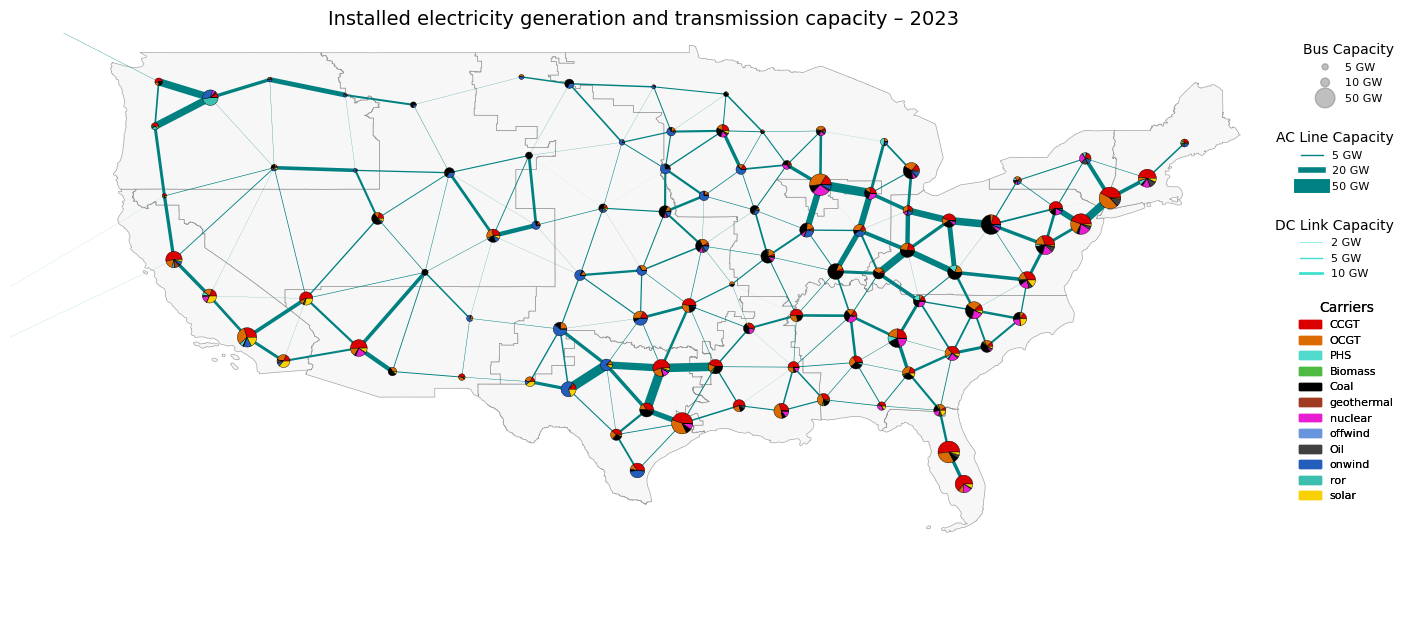

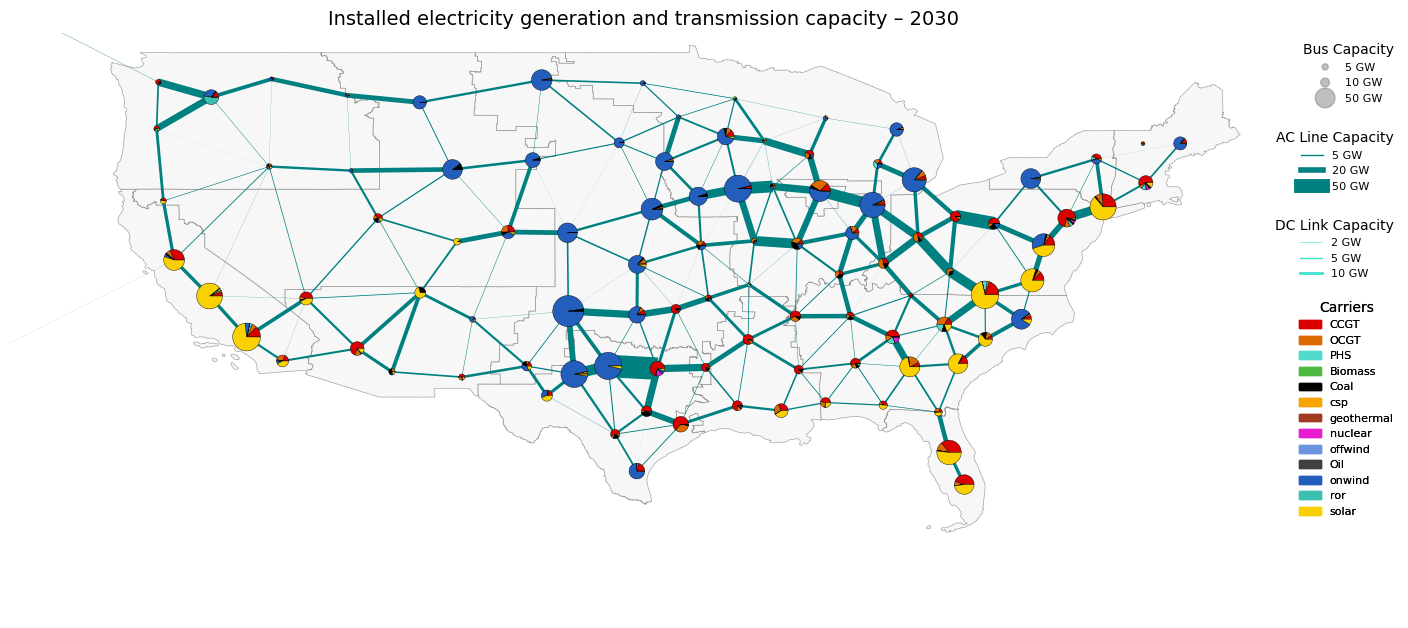

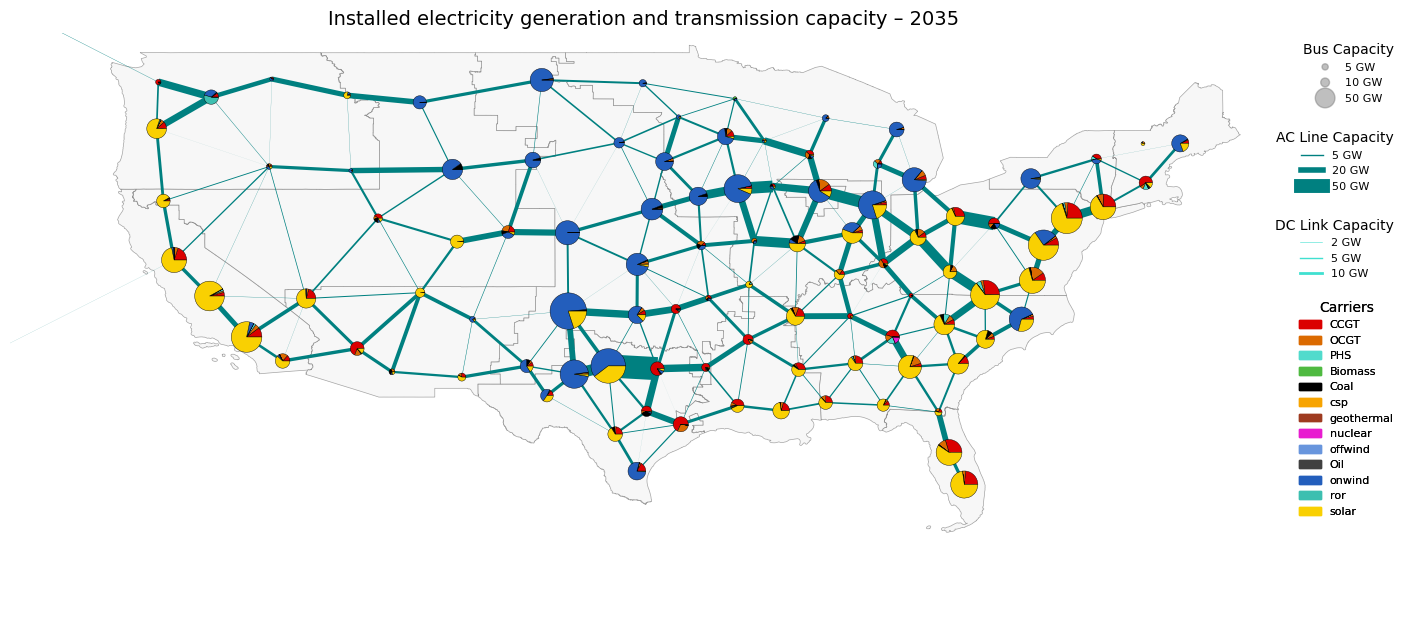

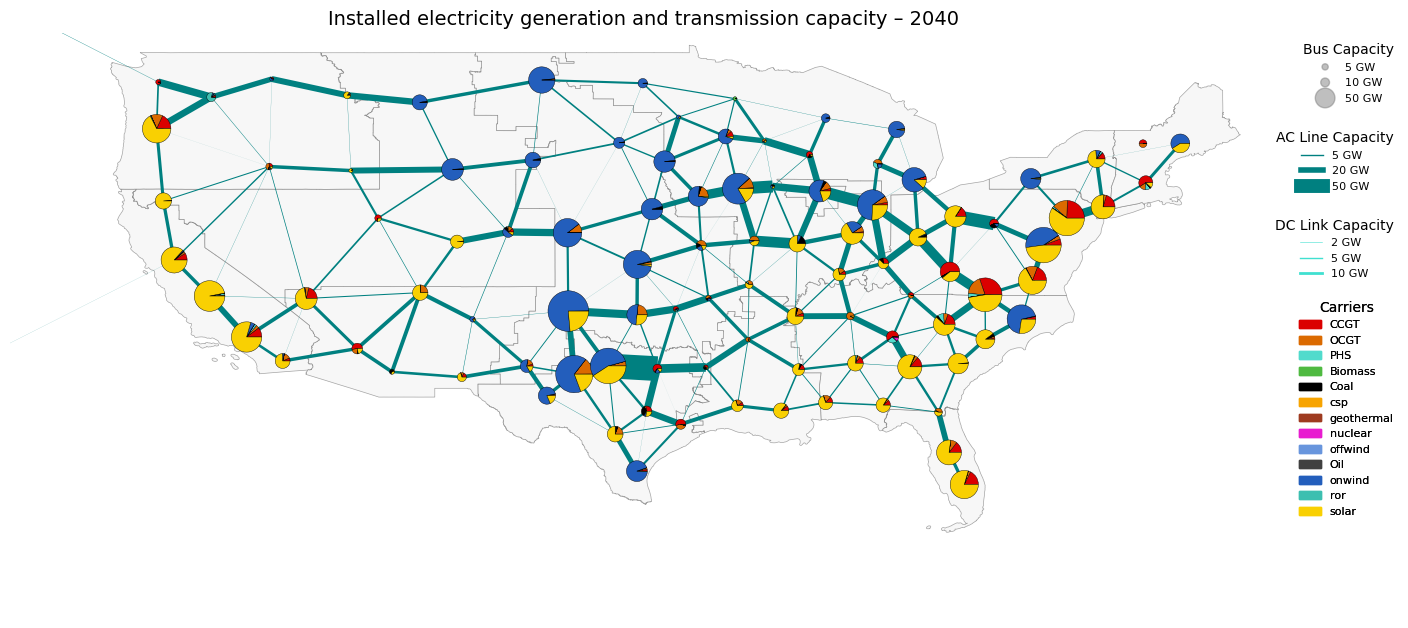

In [22]:
for key, n in networks.items():
    
    # Electricity generators (or links, using efficiency to scale them)
    gen_carriers = {
        "onwind", "offwind-ac", "offwind-dc", "solar", "solar-rooftop",
        "csp", "nuclear", "geothermal", "ror", "PHS", "Reservoir & Dam"
    }
    link_carriers = {
        "OCGT", "CCGT", "coal", "oil", "biomass", "biomass CHP", "gas CHP"
    }
    
    gen_p_nom_opt = n.generators[n.generators.carrier.isin(gen_carriers)]
    gen_p_nom_opt = gen_p_nom_opt.groupby(["bus", "carrier"]).p_nom_opt.sum()
    
    sto_p_nom_opt = n.storage_units[n.storage_units.carrier.isin(gen_carriers)]
    sto_p_nom_opt = sto_p_nom_opt.groupby(["bus", "carrier"]).p_nom_opt.sum()
    
    link_mask = (
        n.links.efficiency.notnull()
        & (n.links.p_nom_opt > 0)
        & n.links.carrier.isin(link_carriers)
    )
    electricity_links = n.links[link_mask].copy()
    electricity_links["electric_output"] = electricity_links.p_nom_opt * electricity_links.efficiency
    link_p_nom_opt = electricity_links.groupby(["bus1", "carrier"]).electric_output.sum()
    link_p_nom_opt.index = link_p_nom_opt.index.set_names(["bus", "carrier"])
    
    # Join all contributors to electricity generators
    bus_carrier_capacity = pd.concat([gen_p_nom_opt, sto_p_nom_opt, link_p_nom_opt])
    bus_carrier_capacity = bus_carrier_capacity.groupby(level=[0, 1]).sum()
    bus_carrier_capacity = bus_carrier_capacity[bus_carrier_capacity > 0]
    
    # Valid coordinates for buses
    valid_buses = n.buses.dropna(subset=["x", "y"])
    valid_buses = valid_buses[
        (valid_buses["x"] > -200) & (valid_buses["x"] < 200) &
        (valid_buses["y"] > -90) & (valid_buses["y"] < 90)
    ]
    
    # Merge offwind-ac and offwind-dc into a single 'offwind' category
    bus_carrier_capacity = bus_carrier_capacity.reset_index()
    bus_carrier_capacity['carrier'] = bus_carrier_capacity['carrier'].replace({
        'offwind-ac': 'offwind',
        'offwind-dc': 'offwind'
    })
    bus_carrier_capacity = bus_carrier_capacity.groupby(['bus', 'carrier'], as_index=False).sum()
    bus_carrier_capacity = bus_carrier_capacity.set_index(['bus', 'carrier']).squeeze()

    # Capacity per bus and carrier
    capacity_df = bus_carrier_capacity.unstack(fill_value=0)
    capacity_df = capacity_df.loc[capacity_df.index.intersection(valid_buses.index)]
    
    fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={"projection": ccrs.PlateCarree()})
    bbox = box(-130, 20, -60, 50)
    regions_onshore_clipped = regions_onshore.to_crs(epsg=4326).clip(bbox)
    
    # Setup Map
    regions_onshore_clipped.plot(
        ax=ax,
        facecolor='whitesmoke',
        edgecolor='gray',
        alpha=0.7,
        linewidth=0.5,
        zorder=0,
    )

    original_links = n.links.copy()
    n.links = n.links[n.links.index.isin(electricity_links.index)]
    
    # Plot
    line_scale = 5e3
    n.plot(
        ax=ax,
        bus_sizes=0,
        bus_alpha=0,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors='teal',
        link_colors='turquoise',
        color_geomap=False,
        flow=None,
    )
    
    n.links = original_links

    # Pie chart for capacities
    pie_scale = 0.003
    for bus_id, capacities in capacity_df.iterrows():
        x, y = valid_buses.loc[bus_id, ['x', 'y']]
        if not bbox.contains(gpd.points_from_xy([x], [y])[0]):
            continue
    
        values = capacities.values
        total = values.sum()
        if total == 0:
            continue
    
        size = np.clip(np.sqrt(total) * pie_scale, 0.1, 1.5)
        colors = [tech_colors.get(c, 'gray') for c in capacities.index]
    
        start_angle = 0
        for val, color in zip(values, colors):
            if val == 0:
                continue
            angle = 360 * val / total  # proporzione rispetto al totale del nodo
            wedge = Wedge(
                center=(x, y),
                r=size,
                theta1=start_angle,
                theta2=start_angle + angle,
                facecolor=color,
                edgecolor='k',
                linewidth=0.3,
                transform=ccrs.PlateCarree()._as_mpl_transform(ax),
                zorder=5,
            )
            ax.add_patch(wedge)
            start_angle += angle
            
    class HandlerCircle(HandlerPatch):
        def create_artists(self, legend, orig_handle,
                           xdescent, ydescent, width, height, fontsize, trans):
            center = (width / 2, height / 2)
            radius = orig_handle.get_radius()
            p = plt.Circle(center, radius)
            self.update_prop(p, orig_handle, legend)
            p.set_transform(trans)
            return [p]
    
    # Legends
    bus_caps = [5, 10, 50]
    bus_patches = []
    for cap in bus_caps:
        r_in_map = np.sqrt(cap)
        r_pts = r_in_map * fig.dpi * 2
        circ = plt.Circle((0, 0), radius=r_pts / 2 / fig.dpi, color='gray', alpha=0.5)
        bus_patches.append(circ)
    
    bus_legend = ax.legend(
        bus_patches,
        [f"{cap} GW" for cap in bus_caps],
        title="Bus Capacity",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        handler_map={mpatches.Circle: HandlerCircle()},
        loc='upper right',
        bbox_to_anchor=(1.1, 1.0)
    )
    
    ac_caps = [5e3, 20e3, 50e3]
    ac_patches = [
        mlines.Line2D([], [], color='teal', linewidth=cap / line_scale, label=f"{int(cap/1e3)} GW")
        for cap in ac_caps
    ]
    ac_legend = ax.legend(
        handles=ac_patches,
        title="AC Line Capacity",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        loc='upper right',
        bbox_to_anchor=(1.1, 0.85)
    )
    
    dc_caps = [2e3, 5e3, 10e3]
    dc_patches = [
        mlines.Line2D([], [], color='turquoise', linewidth=cap / line_scale, label=f"{int(cap/1e3)} GW")
        for cap in dc_caps
    ]
    dc_legend = ax.legend(
        handles=dc_patches,
        title="DC Link Capacity",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        loc='upper right',
        bbox_to_anchor=(1.1, 0.70)
    )
    
    carrier_handles = [
        mpatches.Patch(color=tech_colors.get(c, 'gray'), label=nice_names.get(c, c))
        for c in sorted(capacity_df.columns) if capacity_df[c].sum() > 0
    ]
    carrier_legend = ax.legend(
        handles=carrier_handles,
        title="Carriers",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        loc='upper right',
        bbox_to_anchor=(1.1, 0.56),
        ncol=1
    )
    
    ax.add_artist(bus_legend)
    ax.add_artist(ac_legend)
    ax.add_artist(dc_legend)
    ax.add_artist(carrier_legend)
        
    ax.set_extent([-130, -65, 20, 50], crs=ccrs.PlateCarree())
    ax.autoscale(False)
    
    year = key[-4:]  # Extract the year
    ax.set_title(f"Installed electricity generation and transmission capacity – {year}", fontsize=14)
    
    plt.tight_layout()
    plt.show()

In [23]:
totals_by_carrier = {}

for name, net in networks.items():
    # Define carriers used in the plot
    gen_carriers = {
        "onwind", "offwind-ac", "offwind-dc", "solar", "solar-rooftop",
        "csp", "nuclear", "geothermal", "ror", "PHS", "Reservoir & Dam"
    }
    link_carriers = {
        "OCGT", "CCGT", "coal", "oil", "biomass", "biomass CHP", "gas CHP"
    }

    # Generators
    gen = net.generators.copy()
    gen['carrier'] = gen['carrier'].replace({'offwind-ac': 'offwind', 'offwind-dc': 'offwind'})
    gen = gen[gen.carrier.isin(gen_carriers)]
    gen_totals = gen.groupby('carrier')['p_nom_opt'].sum()

    # Storage
    sto = net.storage_units.copy()
    sto = sto[sto.carrier.isin(gen_carriers)]
    sto_totals = sto.groupby('carrier')['p_nom_opt'].sum()

    # Links (output side scaled by efficiency)
    links = net.links.copy()
    mask = (
        links.efficiency.notnull()
        & (links.p_nom_opt > 0)
        & links.carrier.isin(link_carriers)
    )
    links = links[mask]
    links_totals = links.groupby('carrier').apply(
        lambda df: (df['p_nom_opt'] * df['efficiency']).sum()
    )

    # Combine all
    all_totals = pd.concat([gen_totals, sto_totals, links_totals])
    all_totals = all_totals.groupby(all_totals.index).sum()  # Merge duplicates
    all_totals = all_totals[all_totals > 0]
    totals_by_carrier[name] = all_totals

# Build dataframe
carrier_capacity_df = pd.DataFrame(totals_by_carrier).fillna(0)

# Convert MW → GW
carrier_capacity_df = carrier_capacity_df / 1000
carrier_capacity_df = carrier_capacity_df.round(2)

# Filter: only keep rows with at least one nonzero value
carrier_capacity_df = carrier_capacity_df.loc[carrier_capacity_df.sum(axis=1) > 0]

# Add label
carrier_capacity_df.index.name = "carrier (GW)"

display(carrier_capacity_df)


Base_2023  scenario_02_2030  scenario_02_2035  scenario_02_2040
carrier (GW)                                                                 
CCGT             313.97            287.61            285.79            235.39
OCGT             242.72            137.61            128.57            188.44
PHS               22.01             21.98             21.98             21.98
biomass            9.01              2.22              2.05              1.64
coal             226.98             43.44             33.45             23.88
geothermal         3.89              1.19              1.10              0.82
nuclear           99.96              7.35              2.54              1.27
oil               32.52              3.41              2.19              0.32
onwind           133.42            726.26            819.53            960.06
ror               10.44              9.60              9.60              6.07
solar             60.39            376.90            874.43           1109.73

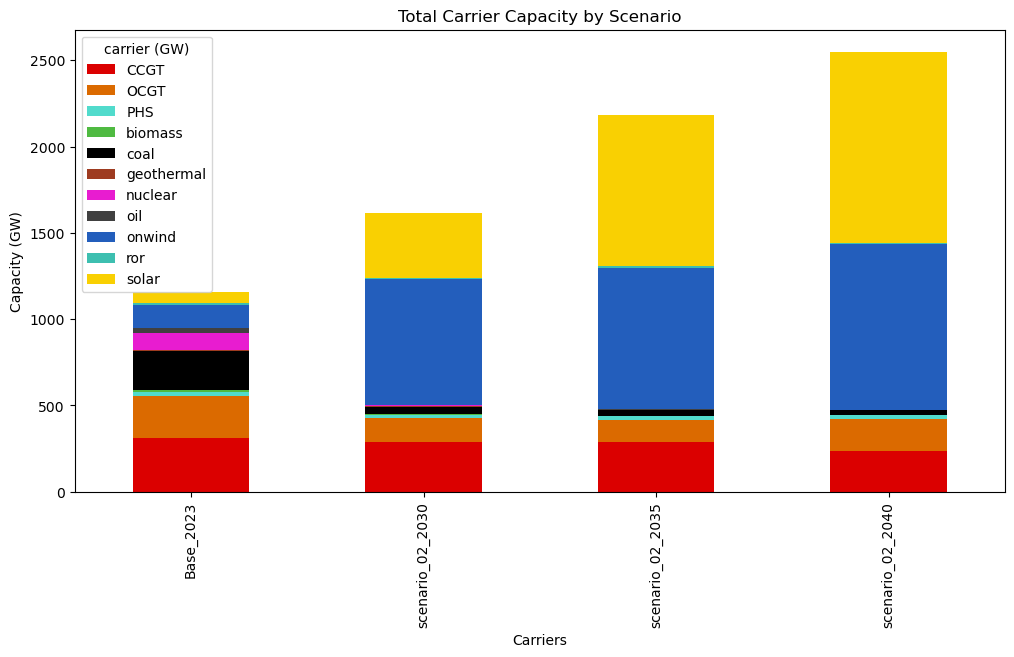

In [24]:
carrier_order = list(carrier_capacity_df.index)
color_list = [tech_colors.get(carrier, 'gray') for carrier in carrier_order]

carrier_capacity_df.T.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    title="Total Carrier Capacity by Scenario",
    ylabel="Capacity (GW)",
    xlabel="Carriers",
    color=color_list,
)
plt.show()

### 4.2. Map: Total Installed Hydrogen Electrolyzer Capacity
*This map visualizes the spatial distribution and total capacity (in GW) of different electrolyzer technologies (e.g., AEL, PEM).*

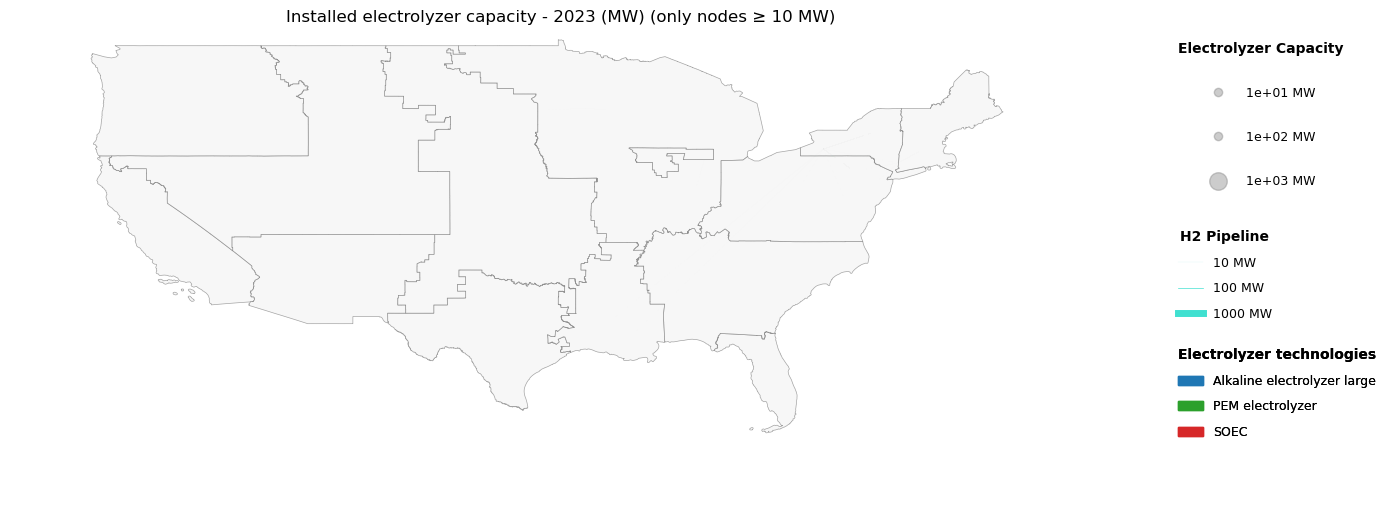

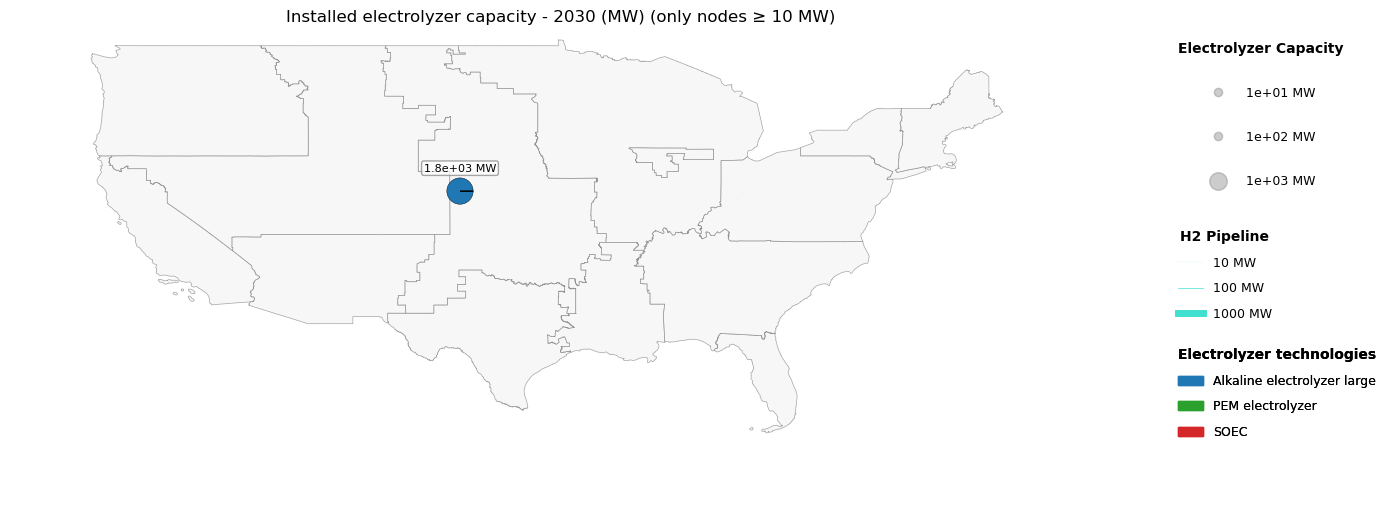

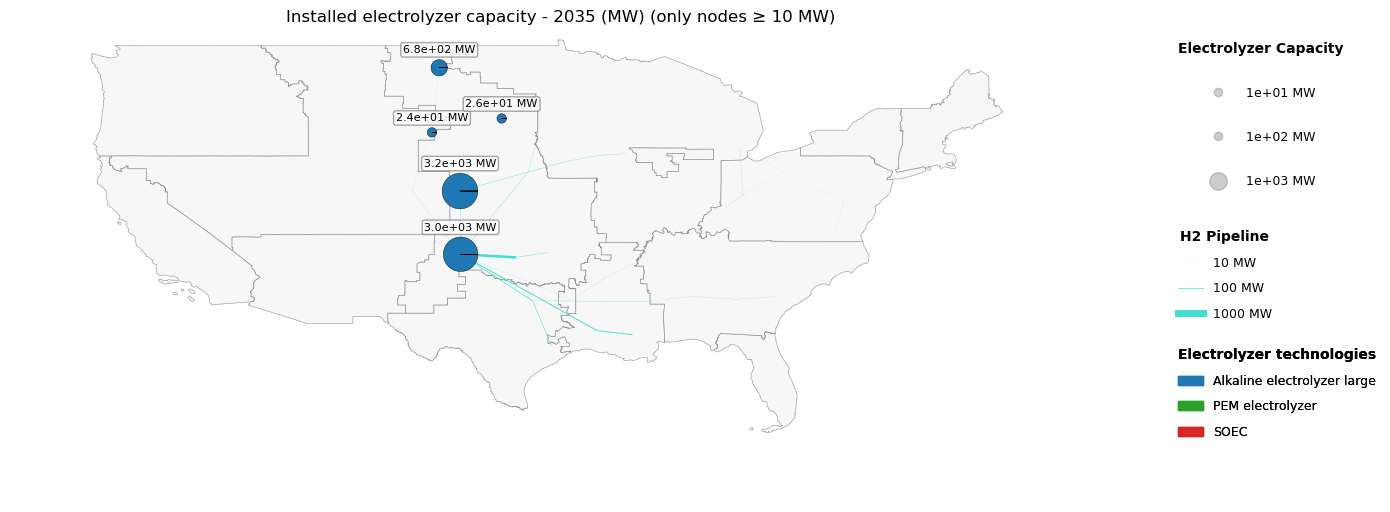

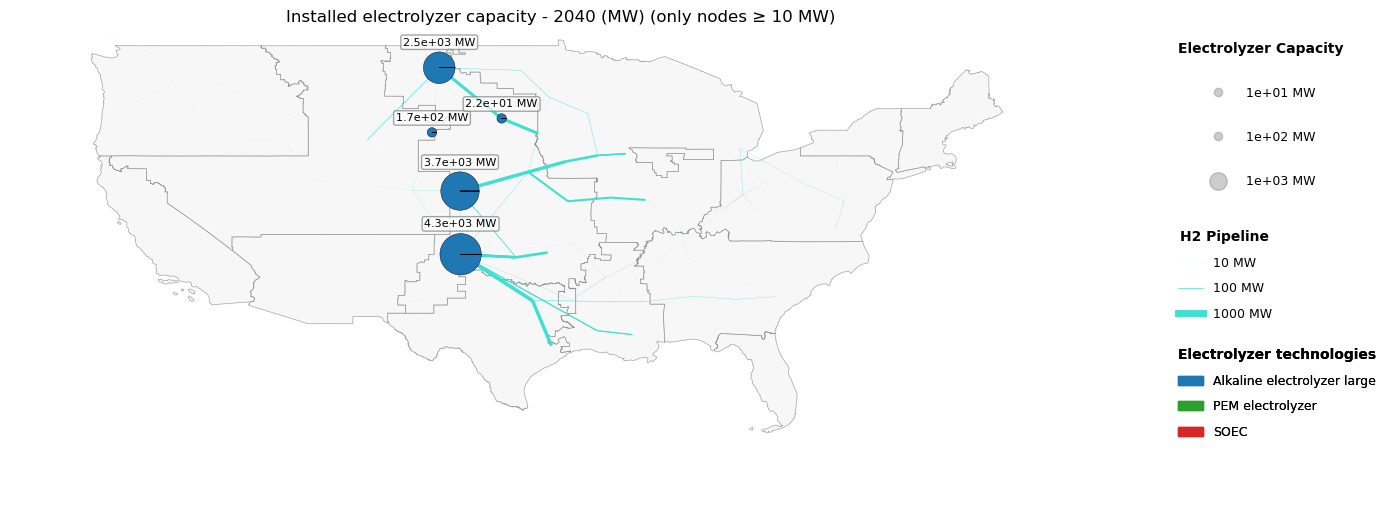

In [25]:
for key, net in networks.items():
    year = key[-4:]
    plot_h2_capacities_map(net, year, tech_colors, nice_names, regions_onshore)

Plotting H2 capacities bar chart for Base_2023...


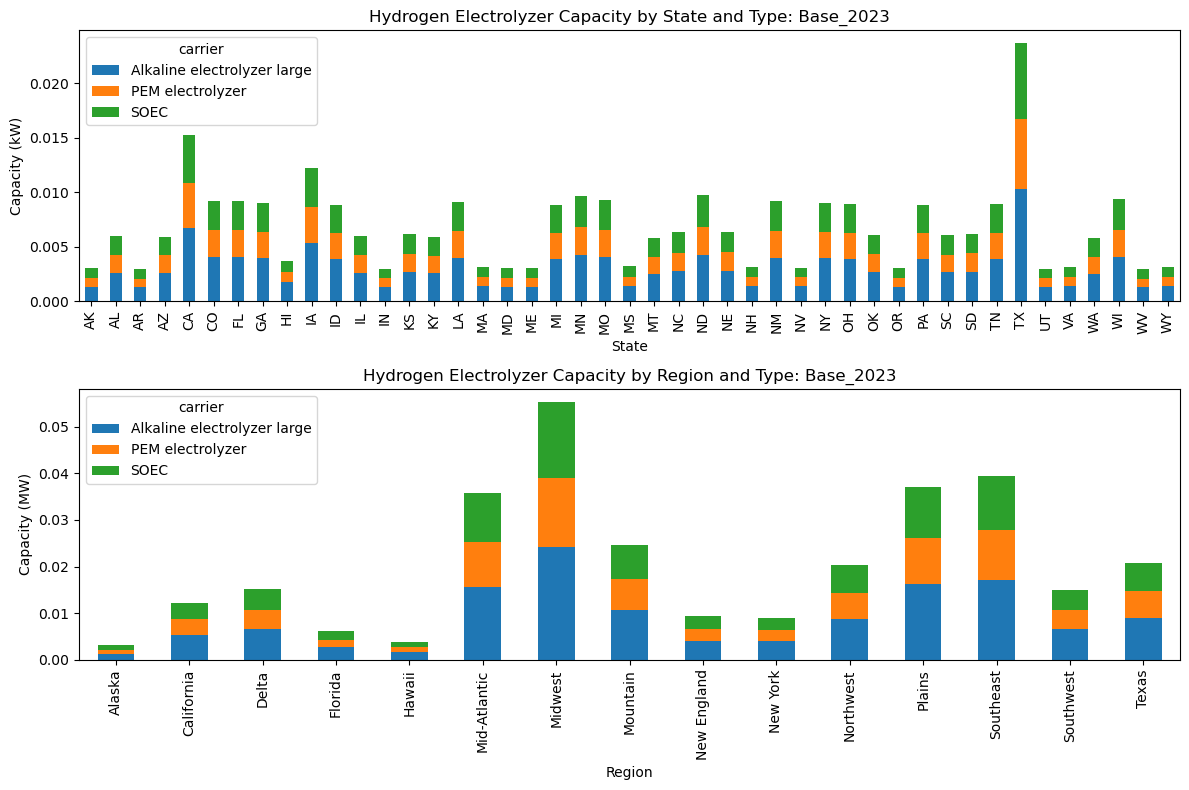

Plotting H2 capacities bar chart for scenario_02_2030...


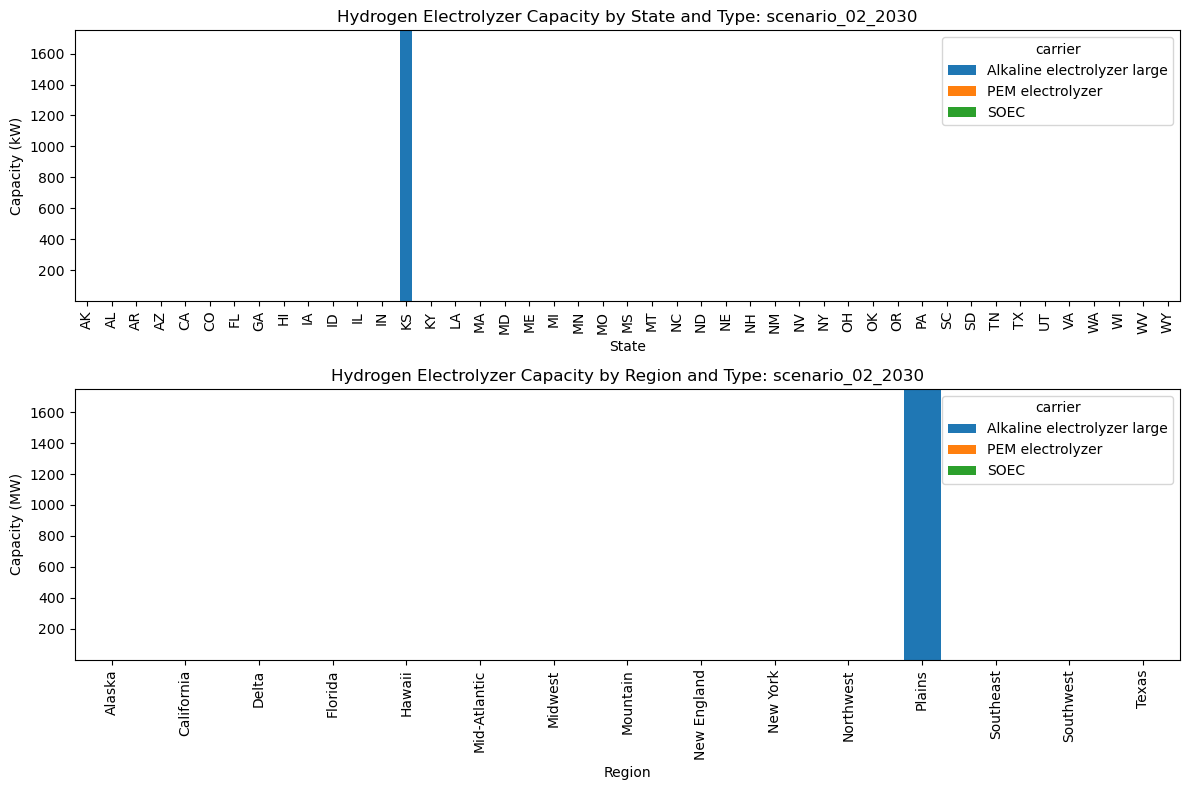

Plotting H2 capacities bar chart for scenario_02_2035...


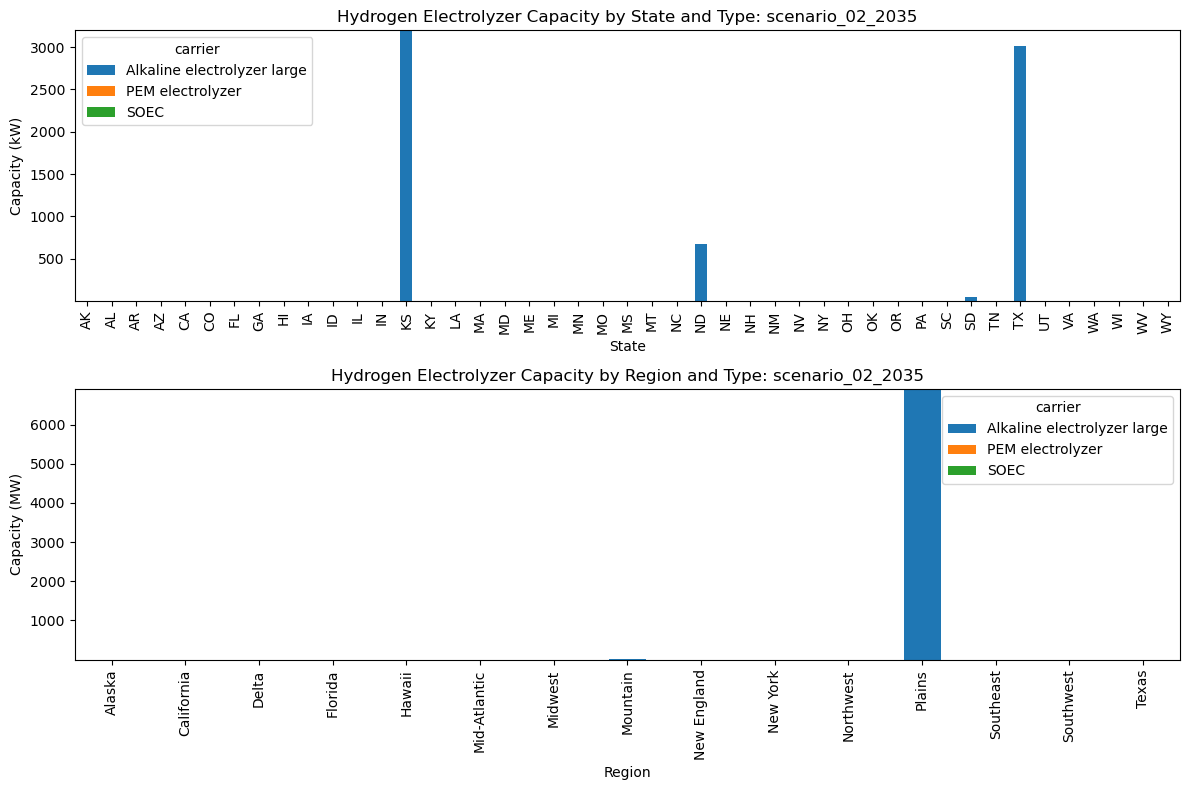

Plotting H2 capacities bar chart for scenario_02_2040...


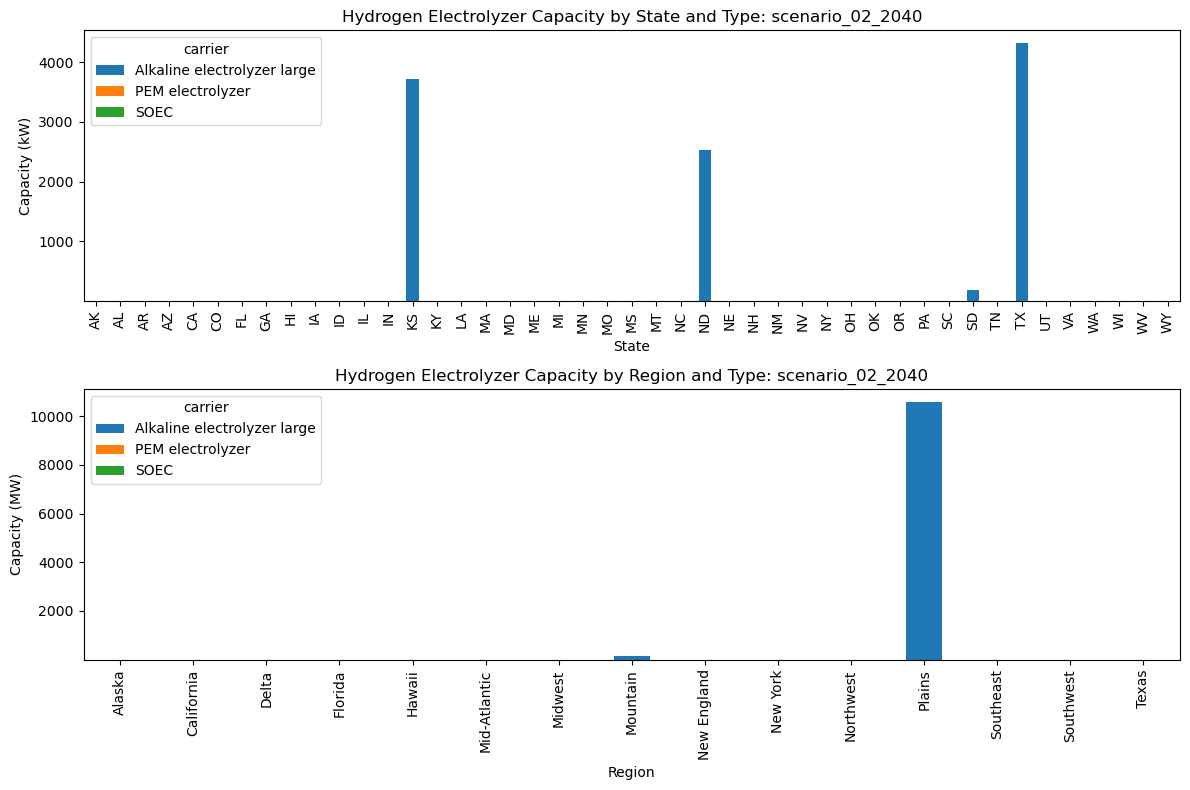

In [26]:
for idx, network in enumerate(networks.keys()):
    print(f"Plotting H2 capacities bar chart for {network}...")
    plot_h2_capacities_bar(networks[network], network)

In [27]:
for idx, network in enumerate(networks.keys()):
    h2_state_cap = compute_h2_capacities(networks[network]).groupby(['state'])[['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC']].sum().round(2)
    print(f"Hydrogen capacities for {network}:")
    from IPython.display import display
    display(h2_state_cap.sort_values(by=list(h2_state_cap.columns), ascending=False).T)

Hydrogen capacities for Base_2023:


state                          TX    CA    IA   AK   AL   AR   AZ   CO   FL  \
carrier                                                                       
Alkaline electrolyzer large  0.01  0.01  0.01  0.0  0.0  0.0  0.0  0.0  0.0   
PEM electrolyzer             0.01  0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0   
SOEC                         0.01  0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0   

state                         GA   HI   ID   IL   IN   KS   KY   LA   MA   MD  \
carrier                                                                         
Alkaline electrolyzer large  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
PEM electrolyzer             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
SOEC                         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

state                         ME   MI   MN   MO   MS   MT   NC   ND   NE   NH  \
carrier                                                                         
Alkaline electrolyzer large  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
PEM electrolyzer             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
SOEC                         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

state                         NM   NV   NY   OH   OK   OR   PA   SC   SD   TN  \
carrier                                                                         
Alkaline electrolyzer large  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
PEM electrolyzer             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
SOEC                         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

state                         UT   VA   WA   WI   WV   WY  
carrier                                                    
Alkaline electrolyzer large  0.0  0.0  0.0  0.0  0.0  0.0  
PEM electrolyzer             0.0  0.0  0.0  0.0  0.0  0.0  
SOEC                         0.0  0.0  0.0  0.0  0.0  0.0

Hydrogen capacities for scenario_02_2030:


state                             KS    TX    SD   AK   AL   AR   AZ   CA  \
carrier                                                                     
Alkaline electrolyzer large  1750.65  0.03  0.01  0.0  0.0  0.0  0.0  0.0   
PEM electrolyzer                0.00  0.00  0.00  0.0  0.0  0.0  0.0  0.0   
SOEC                            0.00  0.00  0.00  0.0  0.0  0.0  0.0  0.0   

state                         CO   FL   GA   HI   IA   ID   IL   IN   KY   LA  \
carrier                                                                         
Alkaline electrolyzer large  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
PEM electrolyzer             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
SOEC                         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

state                         MA   MD   ME   MI   MN   MO   MS   MT   NC   ND  \
carrier                                                                         
Alkaline electrolyzer large  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
PEM electrolyzer             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
SOEC                         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

state                         NE   NH   NM   NV   NY   OH   OK   OR   PA   SC  \
carrier                                                                         
Alkaline electrolyzer large  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
PEM electrolyzer             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
SOEC                         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

state                         TN   UT   VA   WA   WI   WV   WY  
carrier                                                         
Alkaline electrolyzer large  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
PEM electrolyzer             0.0  0.0  0.0  0.0  0.0  0.0  0.0  
SOEC                         0.0  0.0  0.0  0.0  0.0  0.0  0.0

Hydrogen capacities for scenario_02_2035:


state                             KS       TX      ND     SD    IA    MN  \
carrier                                                                    
Alkaline electrolyzer large  3197.44  3009.82  678.27  49.67  0.05  0.04   
PEM electrolyzer                0.01     0.03    0.01   0.01  0.01  0.01   
SOEC                            0.01     0.05    0.01   0.01  0.02  0.02   

state                          NM    CO    CA    ID    MO    OK    WI    NE  \
carrier                                                                       
Alkaline electrolyzer large  0.04  0.04  0.02  0.02  0.02  0.02  0.02  0.02   
PEM electrolyzer             0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.00   
SOEC                         0.02  0.01  0.01  0.01  0.01  0.01  0.01  0.01   

state                          WY    AZ    FL    MI    NY    TN    AR    IL  \
carrier                                                                       
Alkaline electrolyzer large  0.02  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
PEM electrolyzer             0.00  0.01  0.01  0.01  0.01  0.01  0.00  0.00   
SOEC                         0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   

state                          IN    LA    MT    SC    AL    GA    KY    OH  \
carrier                                                                       
Alkaline electrolyzer large  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
PEM electrolyzer             0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
SOEC                         0.01  0.01  0.01  0.01  0.00  0.00  0.00  0.00   

state                          PA    UT    WA   AK   HI   MA   MD   ME   MS  \
carrier                                                                       
Alkaline electrolyzer large  0.01  0.01  0.01  0.0  0.0  0.0  0.0  0.0  0.0   
PEM electrolyzer             0.00  0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0   
SOEC                         0.00  0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0   

state                         NC   NH   NV   OR   VA   WV  
carrier                                                    
Alkaline electrolyzer large  0.0  0.0  0.0  0.0  0.0  0.0  
PEM electrolyzer             0.0  0.0  0.0  0.0  0.0  0.0  
SOEC                         0.0  0.0  0.0  0.0  0.0  0.0

Hydrogen capacities for scenario_02_2040:


state                             TX       KS       ND      SD    IA    MN  \
carrier                                                                      
Alkaline electrolyzer large  4318.19  3722.27  2528.08  189.62  0.08  0.06   
PEM electrolyzer                0.05     0.01     0.01    0.01  0.02  0.02   
SOEC                            0.08     0.02     0.02    0.03  0.03  0.02   

state                          CO    NM    NE    WY    CA    ID    MO    WI  \
carrier                                                                       
Alkaline electrolyzer large  0.06  0.05  0.05  0.04  0.03  0.03  0.03  0.03   
PEM electrolyzer             0.01  0.02  0.01  0.01  0.02  0.01  0.01  0.01   
SOEC                         0.02  0.03  0.01  0.01  0.02  0.02  0.02  0.02   

state                          OK    MI    AZ    FL    MT    AL    AR    GA  \
carrier                                                                       
Alkaline electrolyzer large  0.03  0.02  0.02  0.02  0.02  0.01  0.01  0.01   
PEM electrolyzer             0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
SOEC                         0.01  0.02  0.01  0.01  0.01  0.01  0.01  0.01   

state                          IL    IN    KY    LA    NY    OH    PA    SC  \
carrier                                                                       
Alkaline electrolyzer large  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
PEM electrolyzer             0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
SOEC                         0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   

state                          TN    VA    WA    UT    AK    HI    NV   MA  \
carrier                                                                      
Alkaline electrolyzer large  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.0   
PEM electrolyzer             0.01  0.01  0.01  0.00  0.00  0.00  0.00  0.0   
SOEC                         0.01  0.01  0.01  0.01  0.00  0.00  0.00  0.0   

state                         MD   ME   MS   NC   NH   OR   WV  
carrier                                                         
Alkaline electrolyzer large  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
PEM electrolyzer             0.0  0.0  0.0  0.0  0.0  0.0  0.0  
SOEC                         0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [28]:
for idx, network in enumerate(networks.keys()):
    h2_state_cap = compute_h2_capacities(networks[network]).groupby(['region'])[['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC']].sum().round(2)
    print(f"Year: {network}:")
    display(h2_state_cap.sort_values(by=list(h2_state_cap.columns), ascending=False).T)

Hydrogen capacities for Base_2023:


region                       Midwest  Mid-Atlantic  Plains  Southeast  \
carrier                                                                 
Alkaline electrolyzer large     0.02          0.02    0.02       0.02   
PEM electrolyzer                0.01          0.01    0.01       0.01   
SOEC                            0.02          0.01    0.01       0.01   

region                       Mountain  Northwest  Texas  California  Delta  \
carrier                                                                      
Alkaline electrolyzer large      0.01       0.01   0.01        0.01   0.01   
PEM electrolyzer                 0.01       0.01   0.01        0.00   0.00   
SOEC                             0.01       0.01   0.01        0.00   0.00   

region                       Southwest  Alaska  Florida  Hawaii  New England  \
carrier                                                                        
Alkaline electrolyzer large       0.01     0.0      0.0     0.0          0.0   
PEM electrolyzer                  0.00     0.0      0.0     0.0          0.0   
SOEC                              0.00     0.0      0.0     0.0          0.0   

region                       New York  
carrier                                
Alkaline electrolyzer large       0.0  
PEM electrolyzer                  0.0  
SOEC                              0.0

Hydrogen capacities for scenario_02_2030:


region                        Plains  Midwest  Mountain  Texas  Alaska  \
carrier                                                                  
Alkaline electrolyzer large  1750.69     0.01      0.01   0.01     0.0   
PEM electrolyzer                0.00     0.00      0.00   0.00     0.0   
SOEC                            0.00     0.00      0.00   0.00     0.0   

region                       California  Delta  Florida  Hawaii  Mid-Atlantic  \
carrier                                                                         
Alkaline electrolyzer large         0.0    0.0      0.0     0.0           0.0   
PEM electrolyzer                    0.0    0.0      0.0     0.0           0.0   
SOEC                                0.0    0.0      0.0     0.0           0.0   

region                       New England  New York  Northwest  Southeast  \
carrier                                                                    
Alkaline electrolyzer large          0.0       0.0        0.0        0.0   
PEM electrolyzer                     0.0       0.0        0.0        0.0   
SOEC                                 0.0       0.0        0.0        0.0   

region                       Southwest  
carrier                                 
Alkaline electrolyzer large        0.0  
PEM electrolyzer                   0.0  
SOEC                               0.0

Hydrogen capacities for scenario_02_2035:


region                        Plains  Mountain  Midwest  Texas  Southwest  \
carrier                                                                     
Alkaline electrolyzer large  6911.06     24.15     0.18   0.12       0.04   
PEM electrolyzer                0.04      0.02     0.05   0.03       0.02   
SOEC                            0.06      0.04     0.08   0.04       0.02   

region                       Southeast  Mid-Atlantic  Northwest  California  \
carrier                                                                       
Alkaline electrolyzer large       0.03          0.03       0.03        0.02   
PEM electrolyzer                  0.02          0.02       0.02        0.01   
SOEC                              0.03          0.02       0.02        0.01   

region                       Delta  Florida  New England  New York  Alaska  \
carrier                                                                      
Alkaline electrolyzer large   0.02     0.01         0.01      0.01     0.0   
PEM electrolyzer              0.01     0.01         0.01      0.01     0.0   
SOEC                          0.01     0.01         0.01      0.01     0.0   

region                       Hawaii  
carrier                              
Alkaline electrolyzer large     0.0  
PEM electrolyzer                0.0  
SOEC                            0.0

Hydrogen capacities for scenario_02_2040:


region                         Plains  Mountain  Midwest  Texas  Mid-Atlantic  \
carrier                                                                         
Alkaline electrolyzer large  10589.93    168.22     0.28   0.20          0.05   
PEM electrolyzer                 0.07      0.04     0.09   0.04          0.03   
SOEC                             0.12      0.06     0.13   0.06          0.04   

region                       Southeast  Northwest  Southwest  California  \
carrier                                                                    
Alkaline electrolyzer large       0.05       0.05       0.05        0.02   
PEM electrolyzer                  0.03       0.02       0.02        0.01   
SOEC                              0.04       0.03       0.03        0.02   

region                       Delta  Florida  New England  New York  Alaska  \
carrier                                                                      
Alkaline electrolyzer large   0.02     0.01         0.01      0.01    0.01   
PEM electrolyzer              0.01     0.01         0.01      0.01    0.00   
SOEC                          0.02     0.01         0.01      0.01    0.00   

region                       Hawaii  
carrier                              
Alkaline electrolyzer large    0.01  
PEM electrolyzer               0.00  
SOEC                           0.00

### 4.3. Map: Total Installed Fischer-Tropsch (FT) Capacity
*A map showing where FT synthesis plants are built and their respective capacities, crucial for e-kerosene production.*

Plotting FT map for: Base_2023
Plotting FT map for: scenario_02_2030
Plotting FT map for: scenario_02_2035
Plotting FT map for: scenario_02_2040


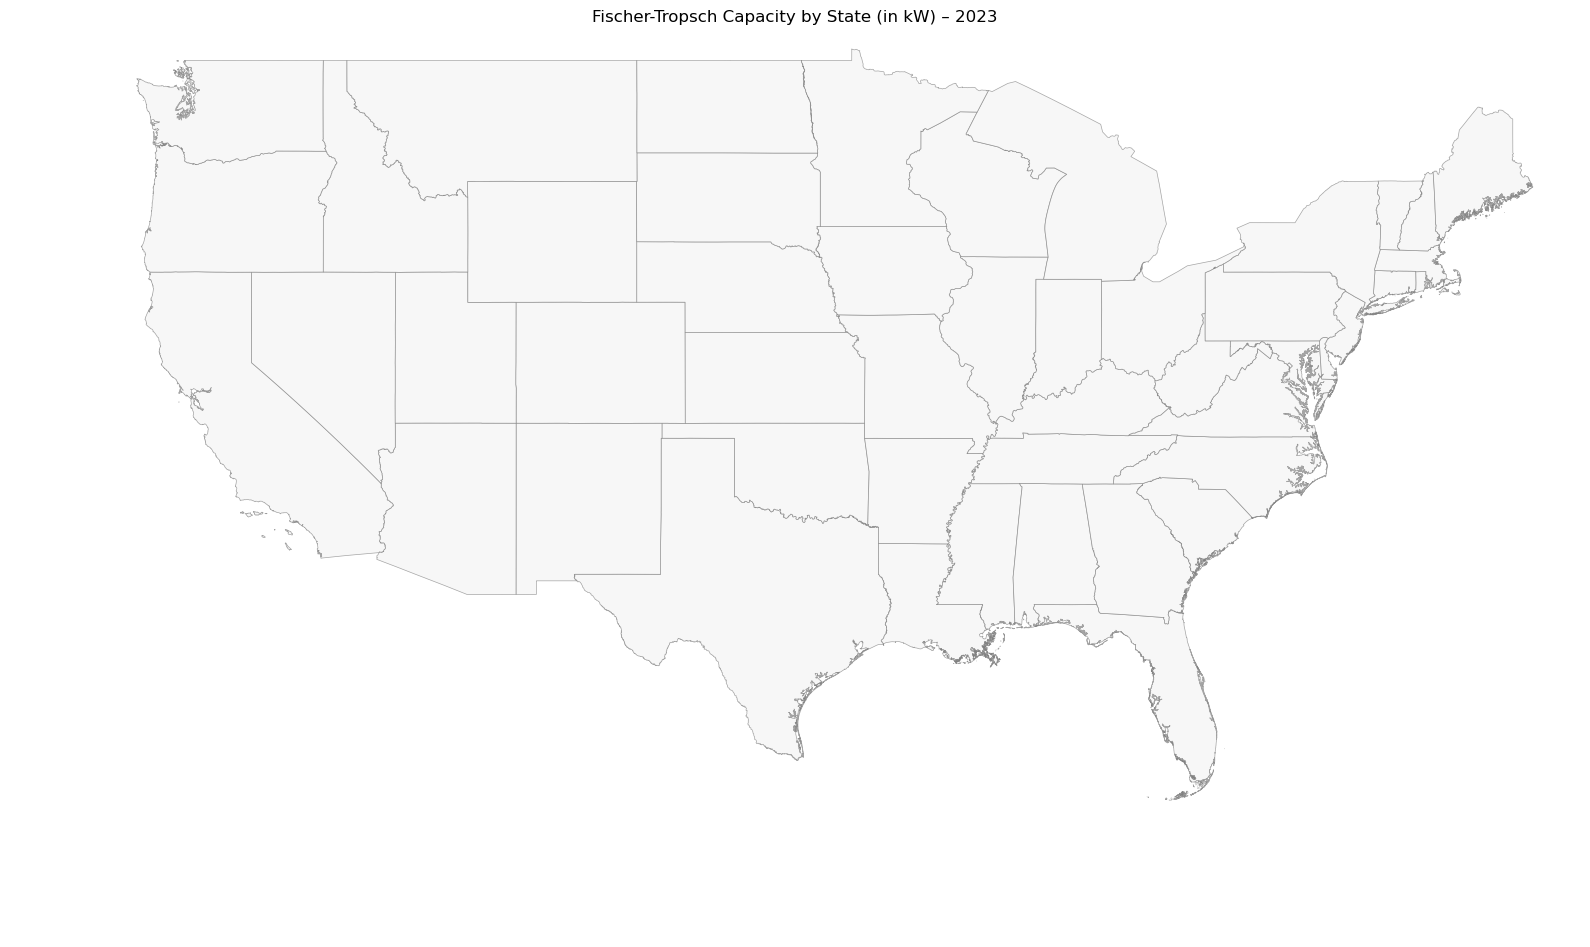

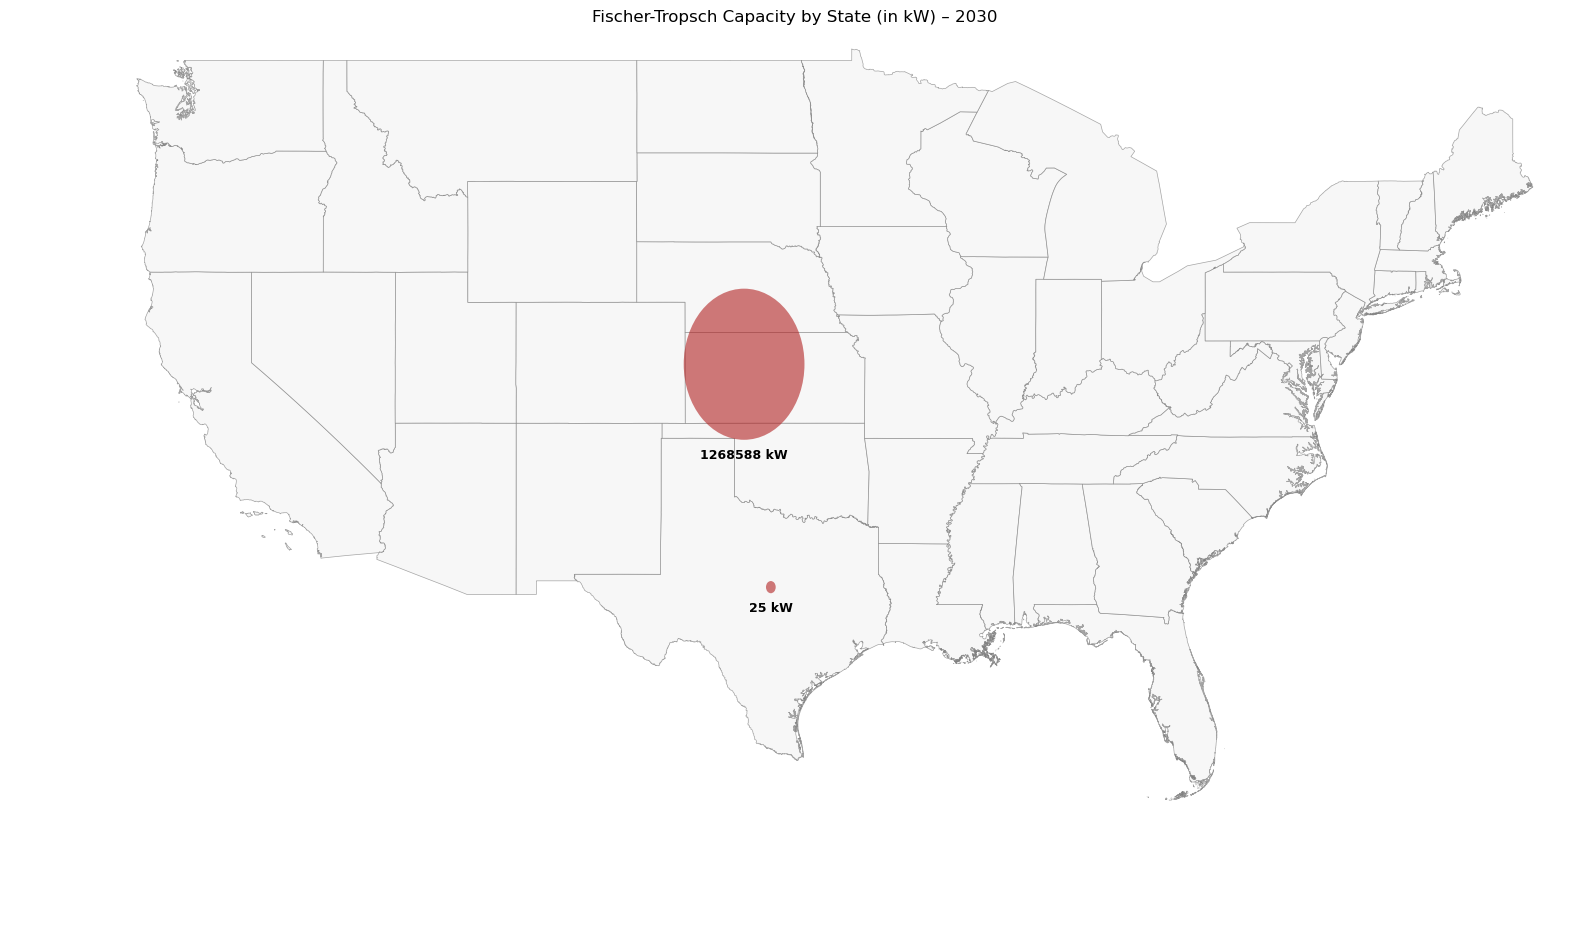

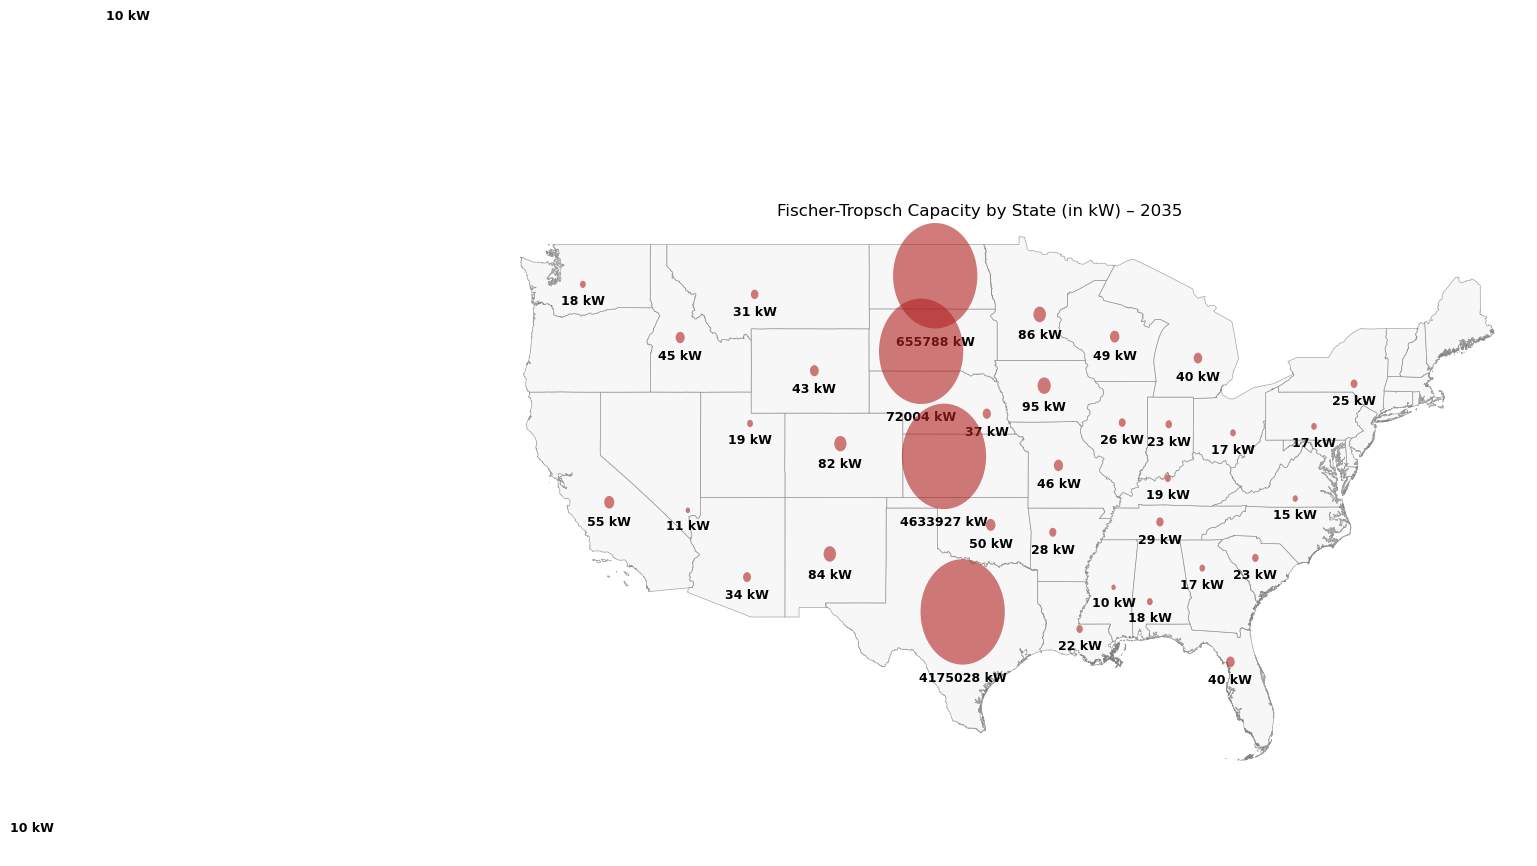

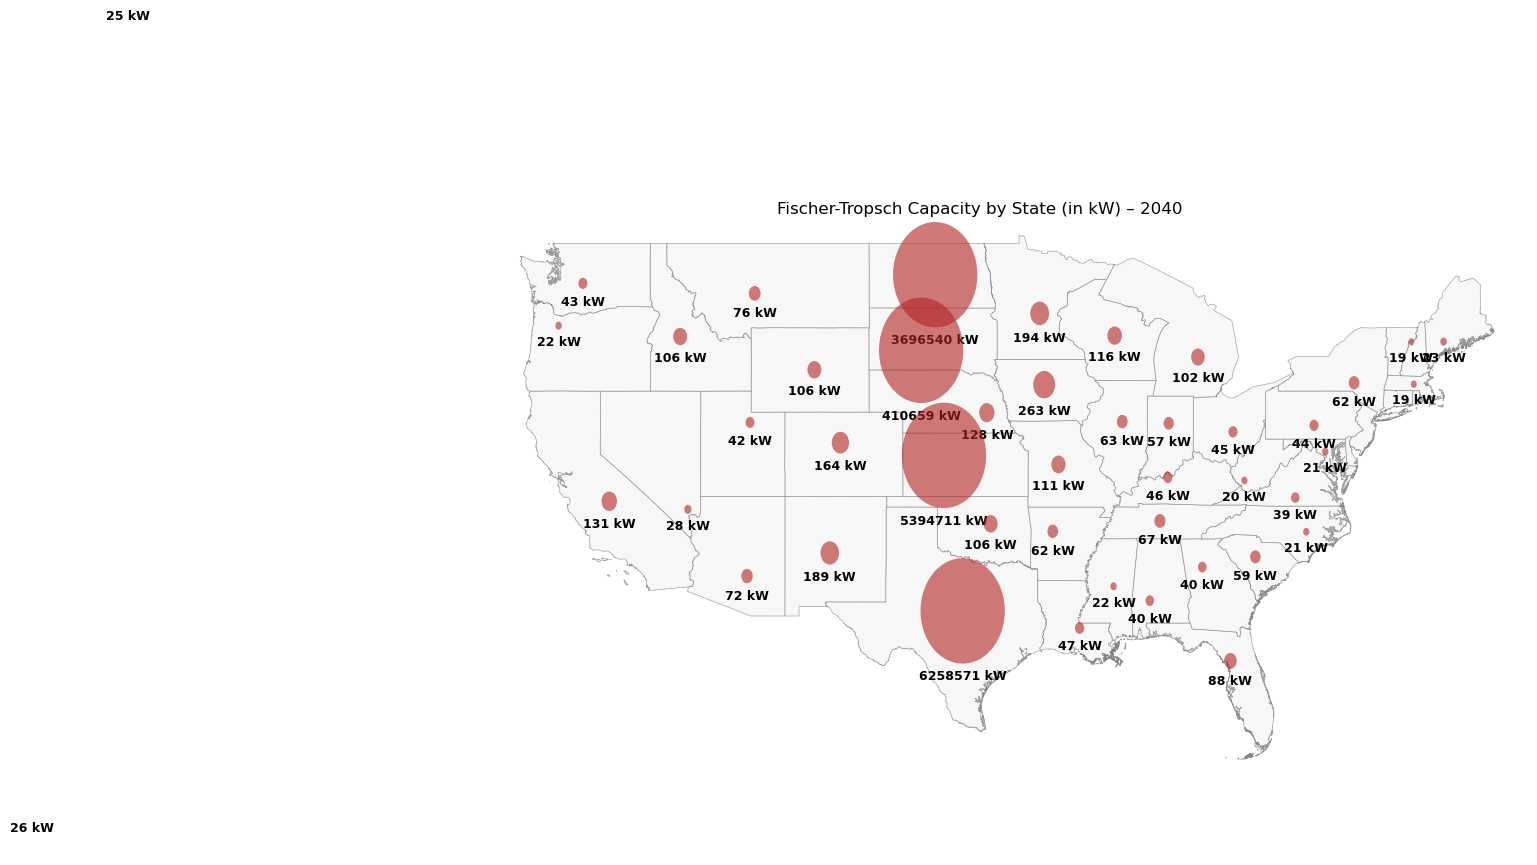

In [29]:
for name, net in networks.items():
    print(f"Plotting FT map for: {name}")
    fig, ax, data = create_ft_capacity_map(
        net.copy(),
        path_shapes=state_shapes_path,
        network_name=name,
        min_capacity_kw=10
    )

Plotting FT map by grid region: Base_2023
Plotting FT map by grid region: scenario_02_2030
Plotting FT map by grid region: scenario_02_2035
Plotting FT map by grid region: scenario_02_2040


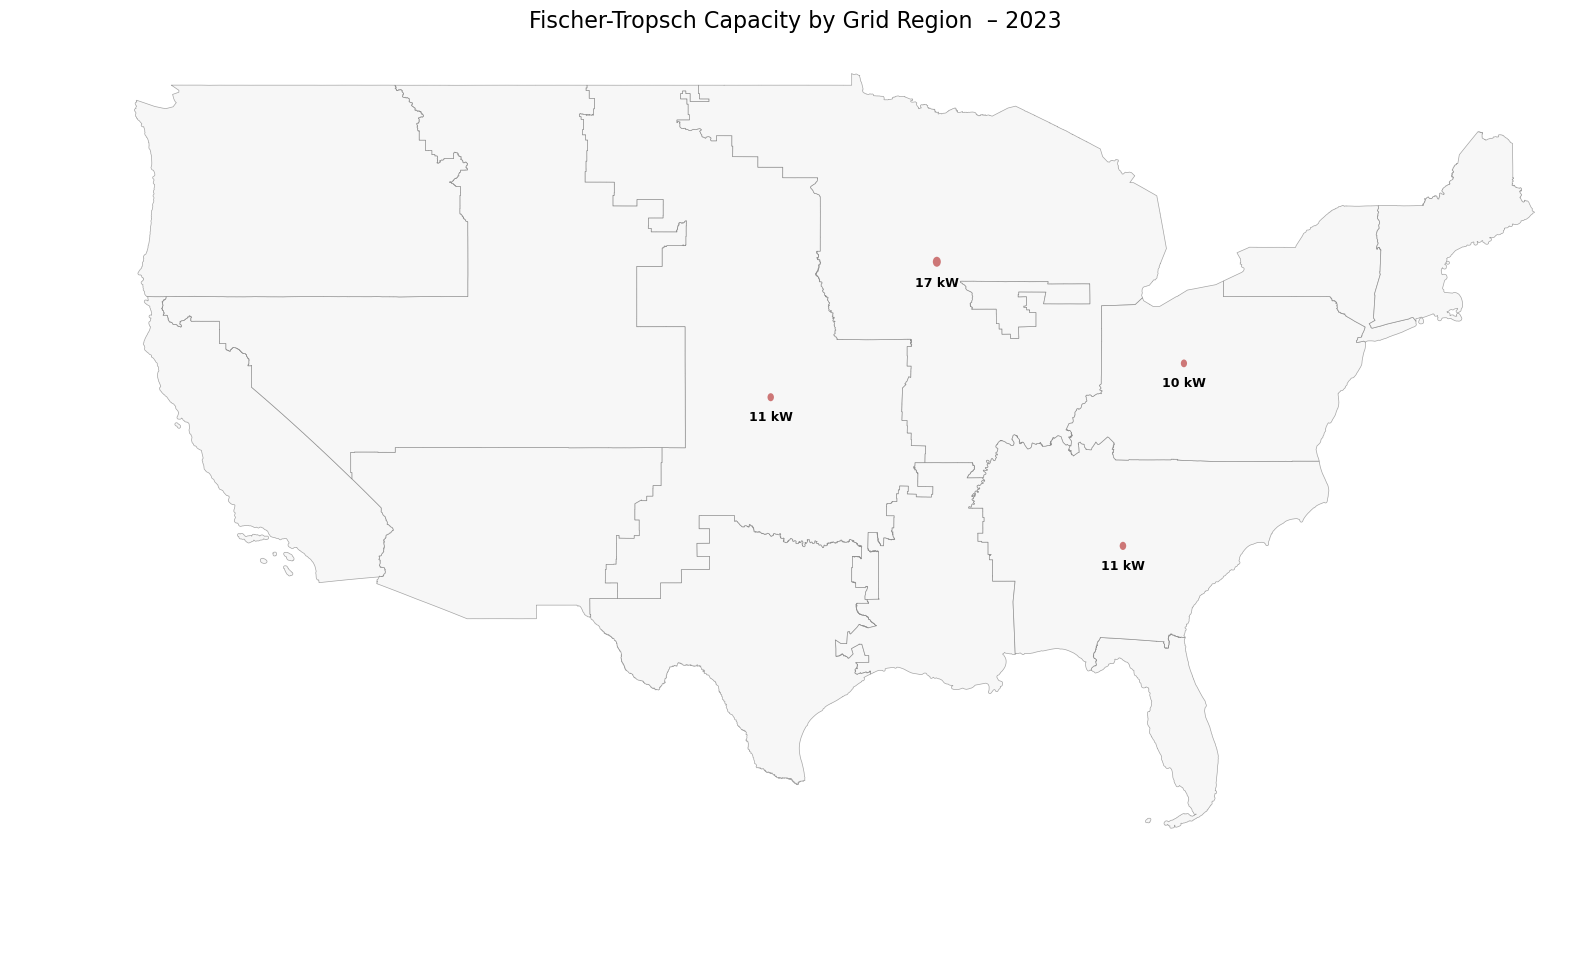

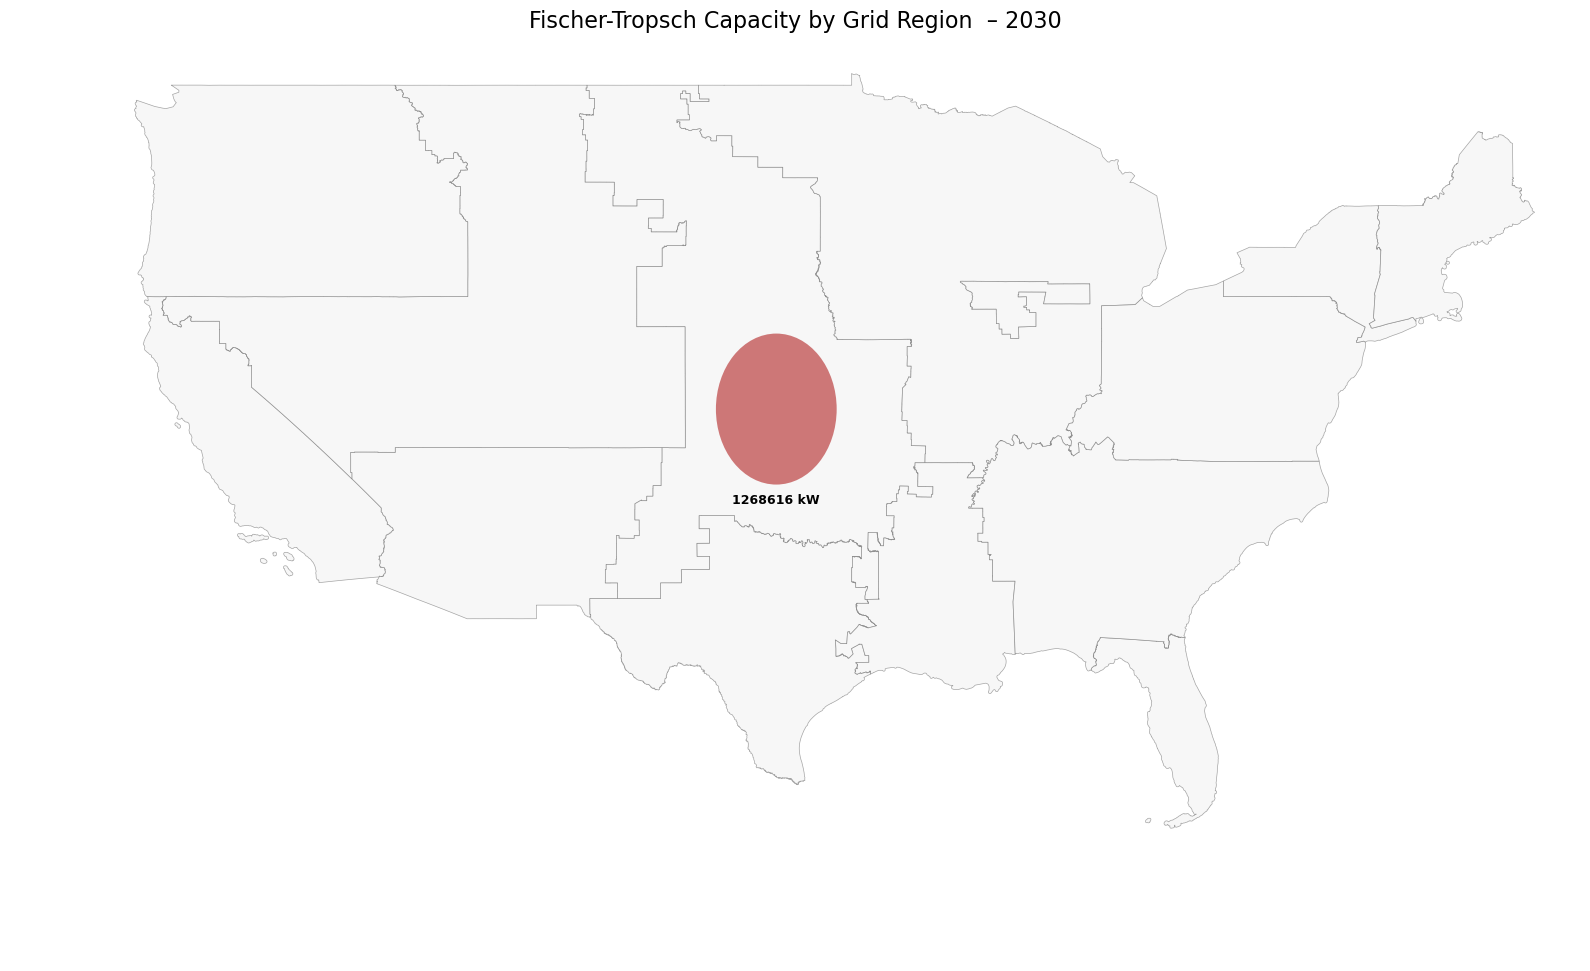

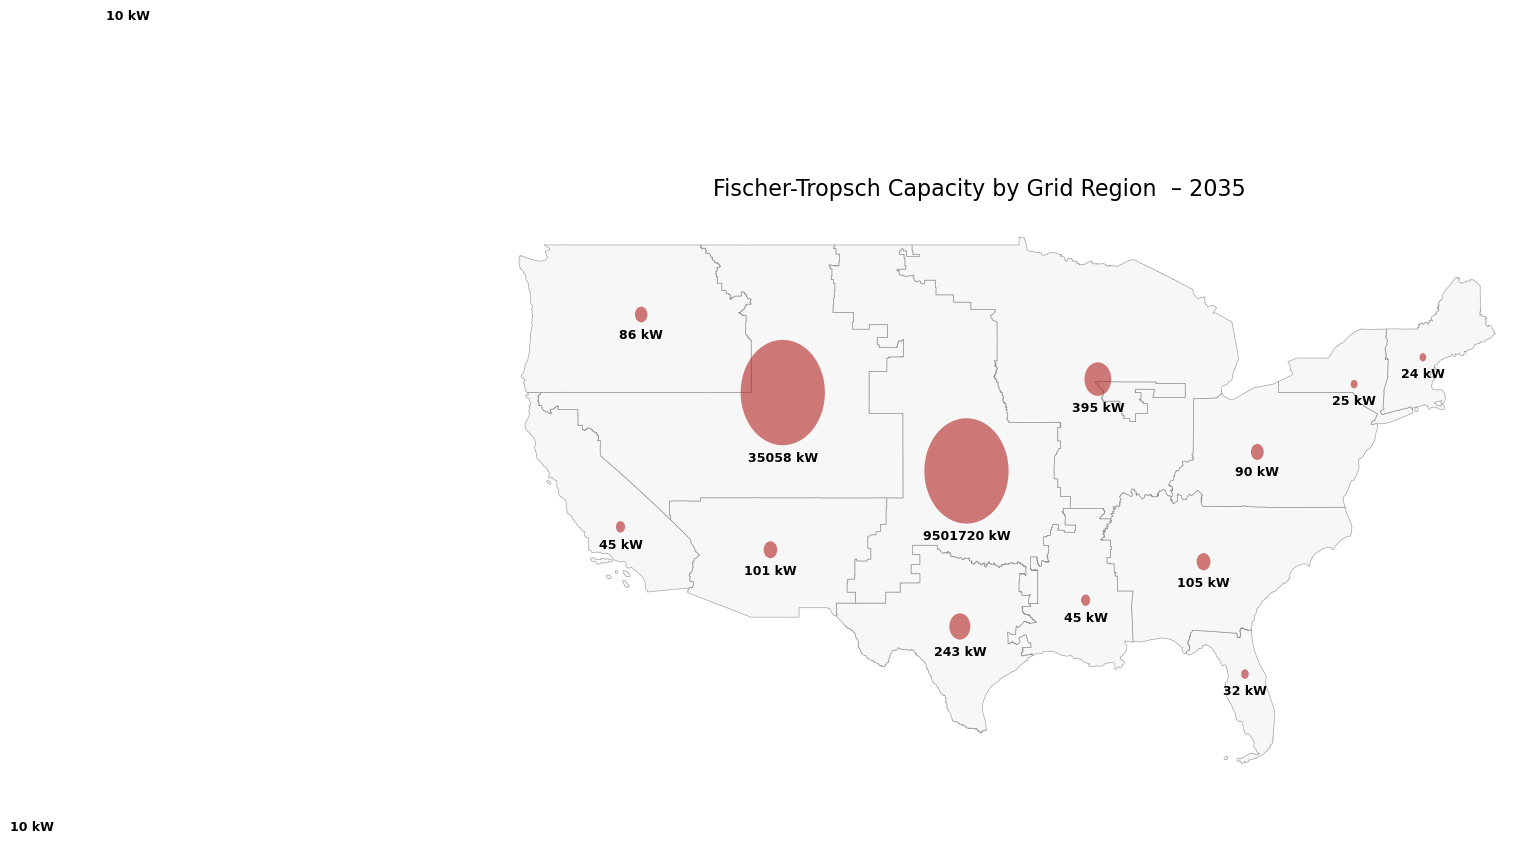

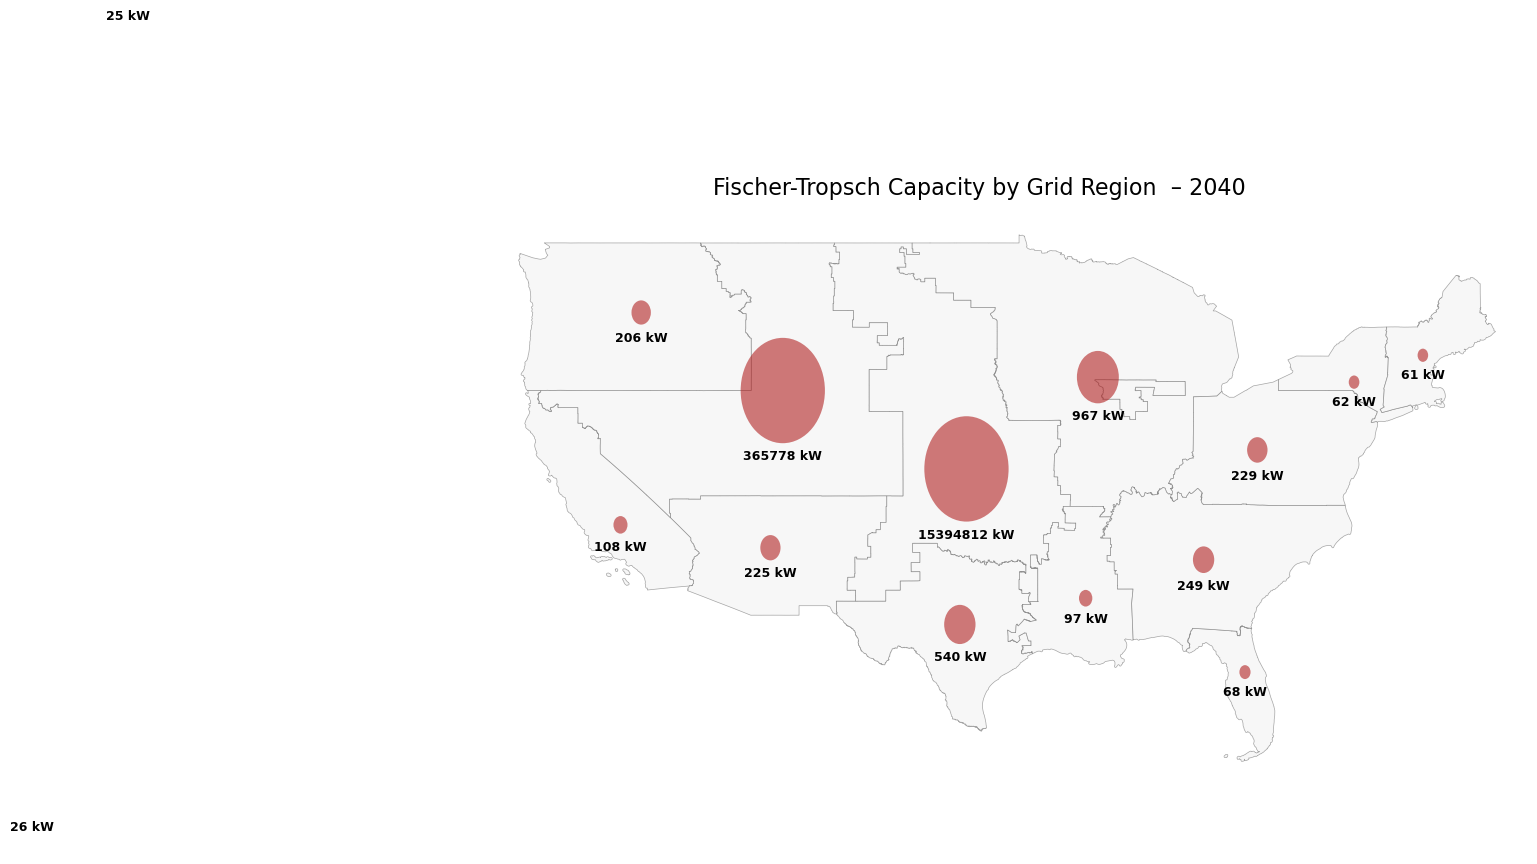

In [30]:
for name, net in networks.items():
    print(f"Plotting FT map by grid region: {name}")
    fig, ax, data = create_ft_capacity_by_grid_region_map(
        net.copy(),
        path_shapes=grid_region_shapes_path,
        network_name=name,
        min_capacity_kw=10
    )

### 4.4. Map: Expanded Capacity per Planning Horizon
*This analysis focuses only on the **newly added** capacity for key technologies (Electricity, H2, FT) within the planning period, rather than the total capacity.*

In [31]:
# Code to calculate the difference between p_nom_opt and p_nom
# and plot the expansion on a map.
pass

---

## 5. Operational Analysis: How Does the System Work?

*This section explores the temporal dispatch of different technologies to meet demand throughout the year.*

### 5.1. Annual Electricity & Hydrogen Dispatch
*A line plot showing the generation from different carriers (for electricity) and production from electrolyzers (for hydrogen) for every hour of the year. This reveals the operational dynamics and intermittency management.*

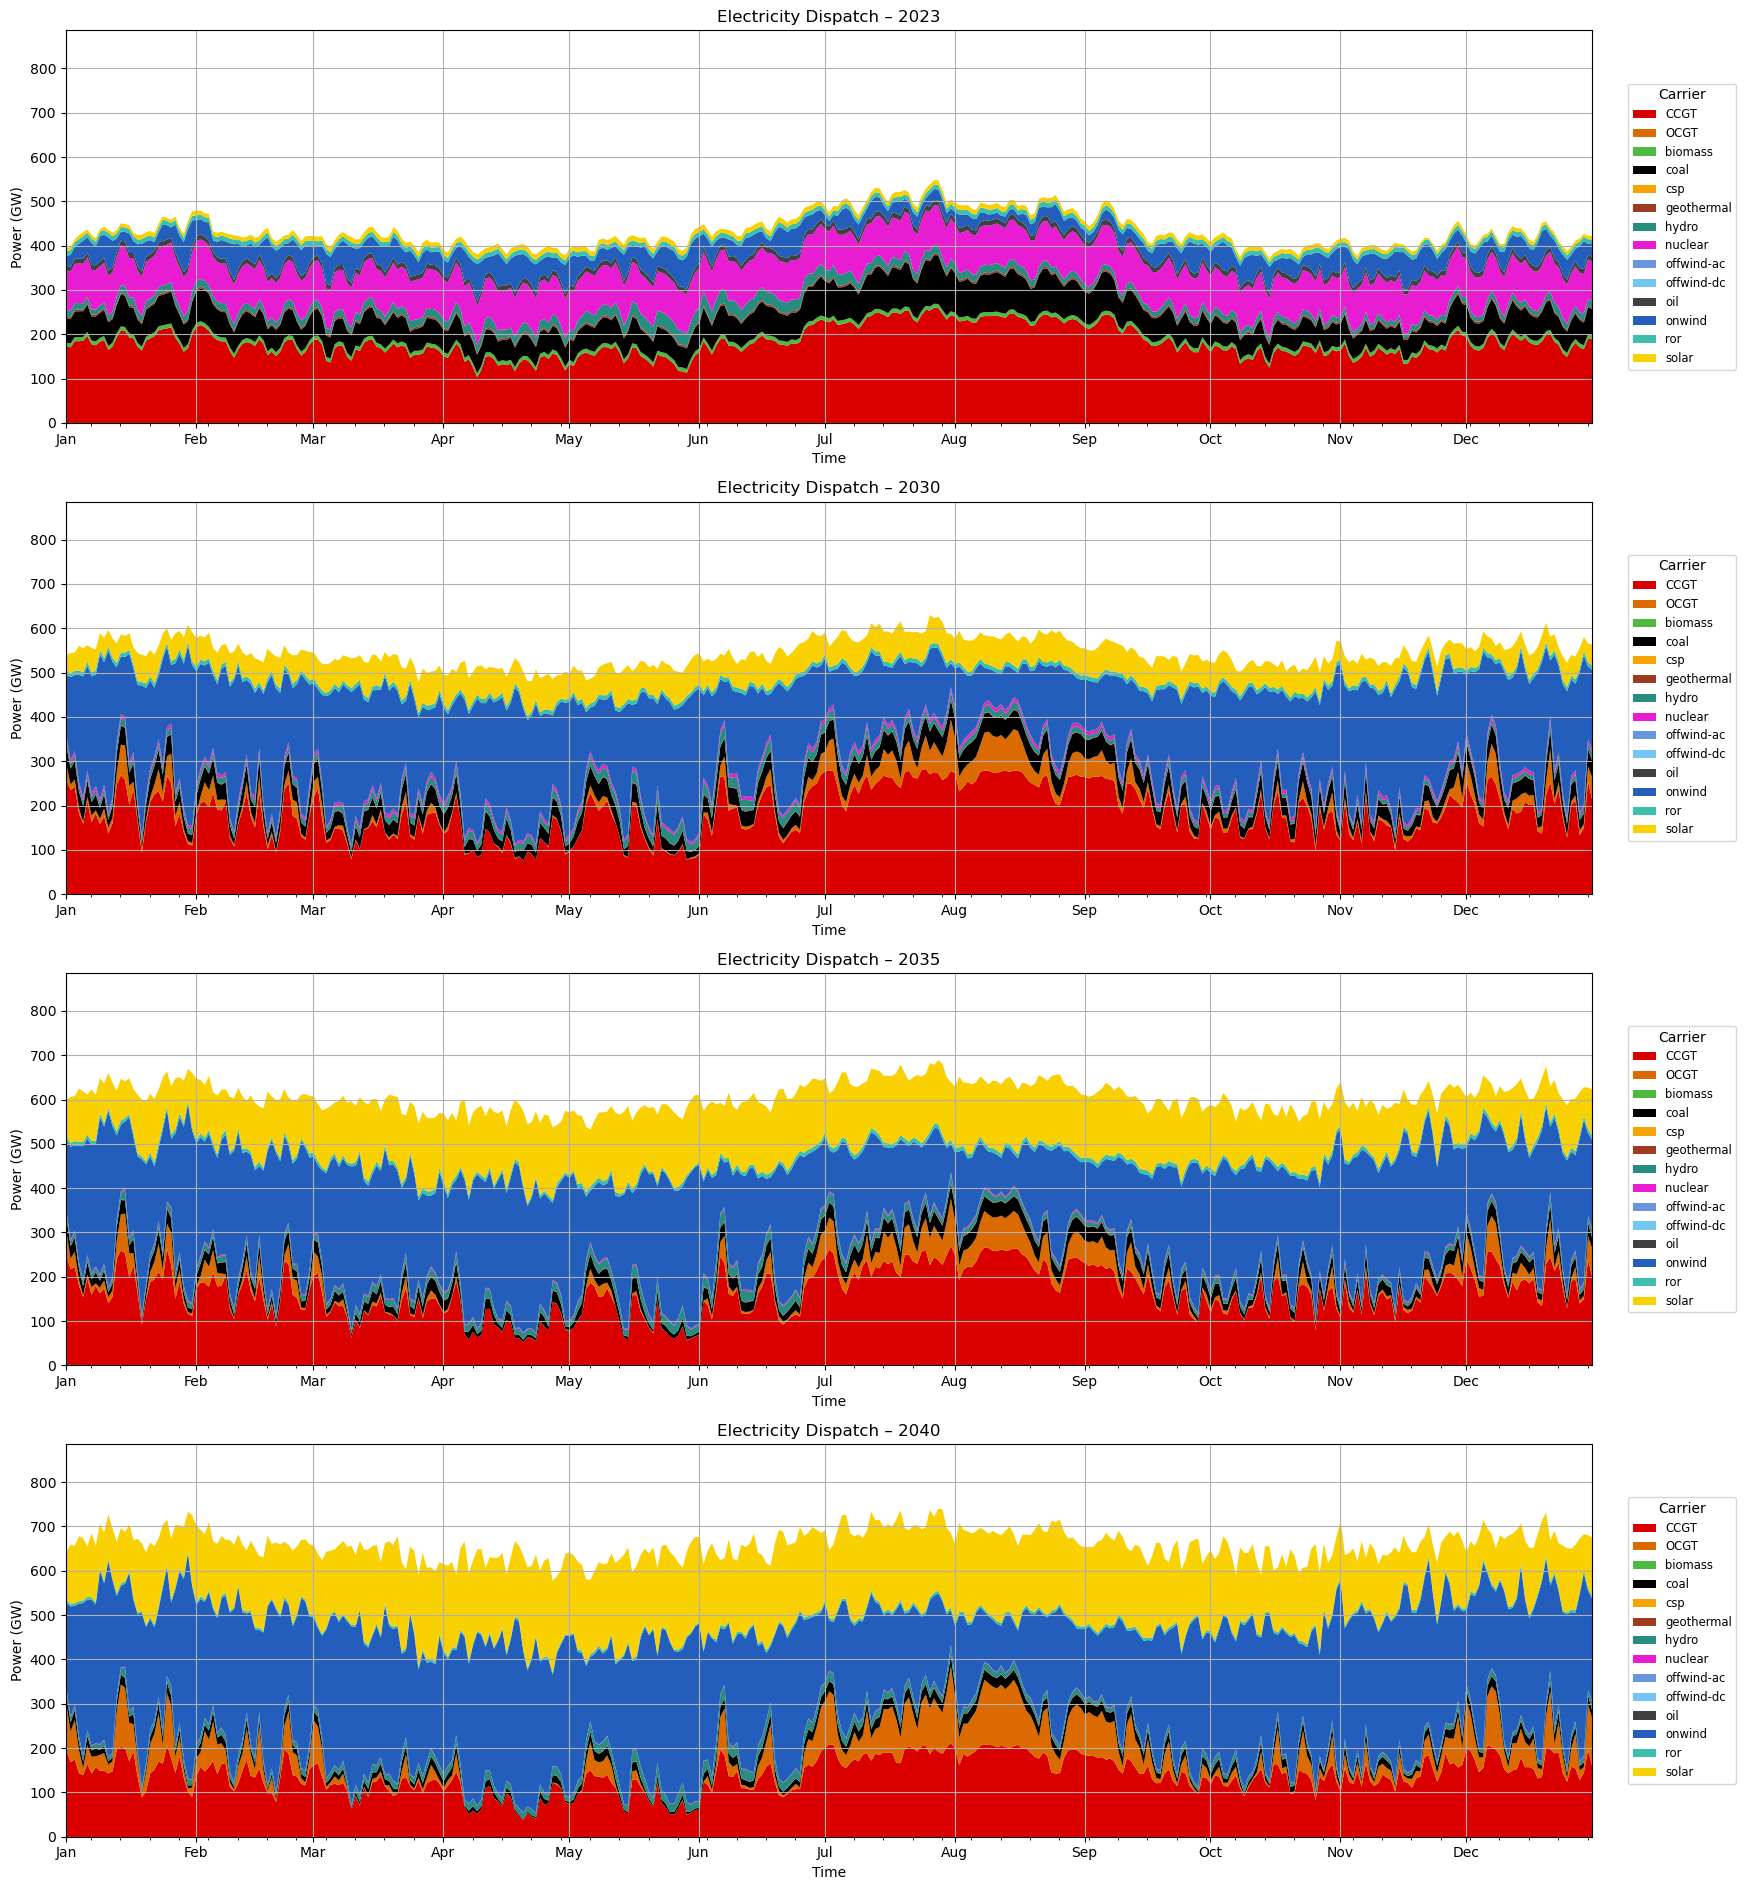

In [32]:
summary_list = []
max_y = 0

for key, n in networks.items():
    total_gwh, supply_gw = calculate_dispatch(n)
    summary_list.append({"Network": key, "Total Dispatch (GWh)": total_gwh})
    max_y = max(max_y, supply_gw.sum(axis=1).max())

ymax = max_y

fig, axes = plt.subplots(len(networks), 1, figsize=(22, 5 * len(networks)))

if len(networks) == 1:
    axes = [axes]

for ax, (key, n) in zip(axes, networks.items()):
    _, supply_gw = calculate_dispatch(n)
    supply_gw.index = pd.to_datetime(supply_gw.index)
    supply_gw = supply_gw.resample('24H').mean()
    
    supply_gw.plot.area(
        ax=ax,
        stacked=True,
        linewidth=0,
        color=[tech_colors.get(c, 'gray') for c in supply_gw.columns],
        legend=False
    )
    
    year = key[-4:]  # Extract the year
    ax.set_title(f"Electricity Dispatch – {year}")
    ax.set_ylabel("Power (GW)")
    ax.set_ylim(0, ymax)
    ax.grid(True)
    
    start = supply_gw.index.min().replace(day=1)
    end = supply_gw.index.max()
    month_starts = pd.date_range(start=start, end=end, freq='MS')
    
    ax.set_xlim(start, end)
    ax.set_xticks(month_starts)
    ax.set_xticklabels(month_starts.strftime('%b'))
    ax.tick_params(axis='x', which='both', labelbottom=True)
    ax.set_xlabel("Time")

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles, labels,
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        title='Carrier',
        fontsize='small',
        title_fontsize='medium'
    )

axes[-1].set_xlabel("Time")
plt.tight_layout(rect=[0, 0.05, 0.80, 1])
plt.show()

In [33]:
generation_summary = {}

for key, network in networks.items():
    year = key[-4:]  # Extract the year
    generation_summary[year] = calculate_total_generation_by_carrier(network)

generation_df = pd.DataFrame.from_dict(generation_summary, orient='index').fillna(0)
generation_df.index.name = "Generation (TWh)"
generation_df = generation_df.sort_index().round(2)

fossil_order = ['coal', 'lignite', 'oil', 'OCGT', 'CCGT', 'biomass']
renewables_order = ['hydro', 'ror', 'solar', 'onwind', 'offwind-ac', 'offwind-dc', 'csp', 'geothermal', 'nuclear']
preferred_order = fossil_order + renewables_order

available_cols = generation_df.columns.tolist()
ordered_cols = [c for c in preferred_order if c in available_cols] + \
               [c for c in available_cols if c not in preferred_order]

generation_df = generation_df[ordered_cols]
generation_df["Total"] = generation_df.sum(axis=1).round(2)

display(generation_df)

coal    oil    OCGT     CCGT  biomass   hydro    ror  \
Generation (TWh)                                                           
2023              536.28  97.66    0.00  1602.36    78.39  155.36  91.49   
2030              301.69  13.23  178.38  1623.26     0.02  125.01  82.07   
2035              206.98   8.86  193.49  1452.84     0.05  121.44  75.12   
2040              140.24   0.68  369.24  1235.95     0.12  120.40  46.58   

                    solar   onwind  offwind-dc  csp  geothermal  nuclear  \
Generation (TWh)                                                           
2023                85.75   350.20         0.0  0.0       34.05   779.33   
2030               513.12  1887.98         0.0  0.0        9.40    56.28   
2035              1148.10  2084.28         0.0  0.0        7.94    19.59   
2040              1448.55  2404.50         0.0  0.0        5.77     9.40   

                    Total  
Generation (TWh)           
2023              3810.87  
2030              4790.44  
2035              5318.69  
2040              5781.43

---

## 6. Economic Analysis: What Are the Unit Costs?

*We break down the system costs to find the levelized cost of key energy vectors in different locations.*

### 6.1. Map: Levelized Cost of Electricity (LCOE)
*A map displaying the LCOE for each grid region.*

In [34]:
shapes = gpd.read_file(grid_region_shapes_path)

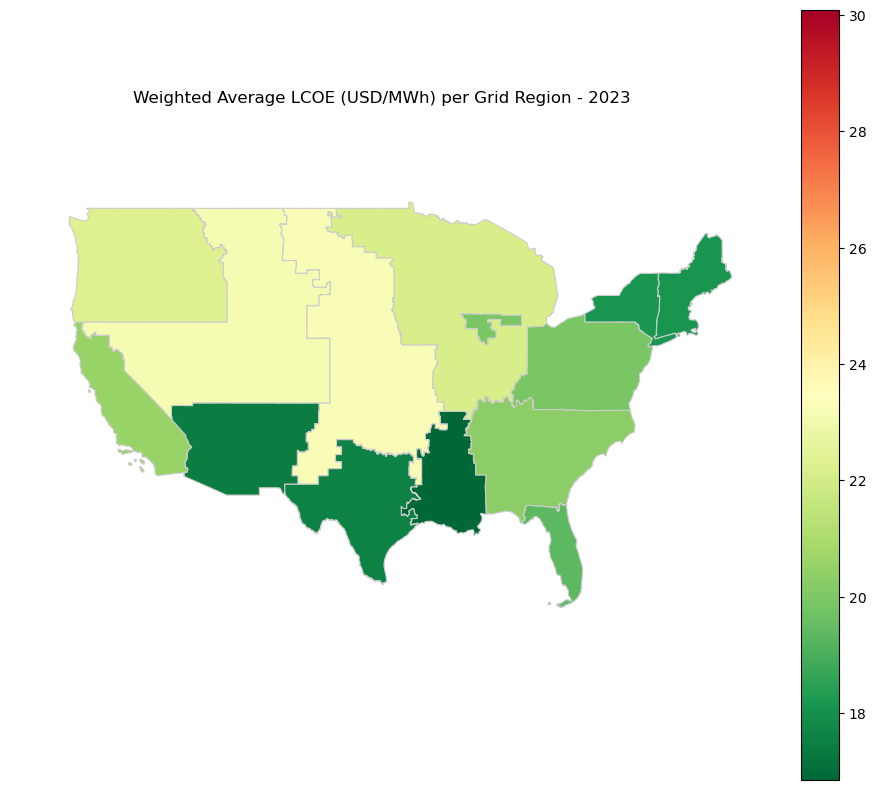

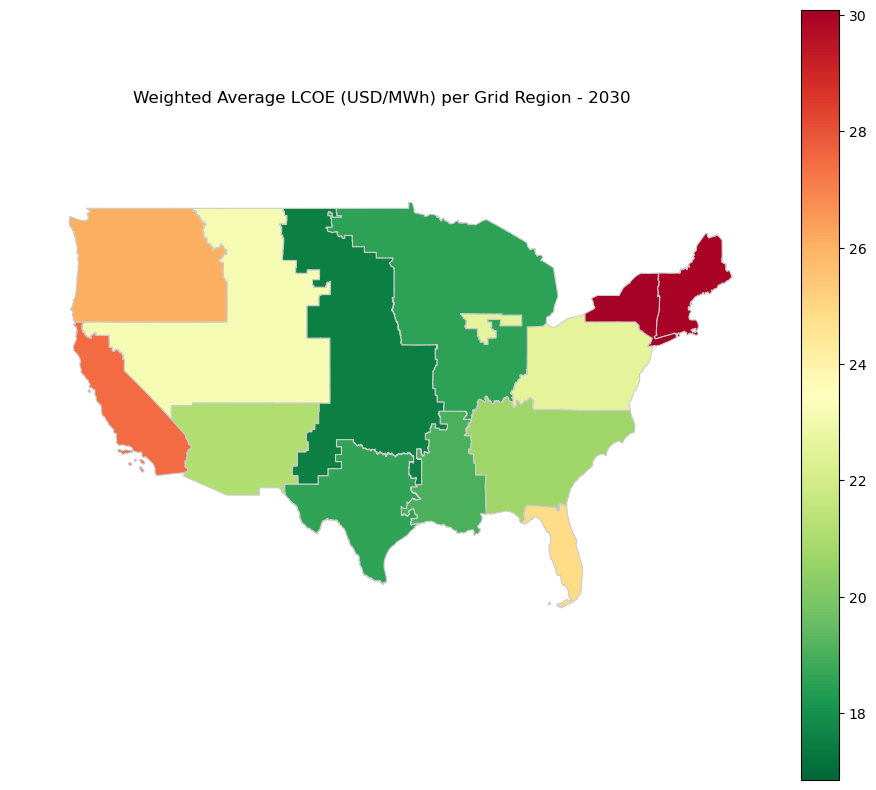

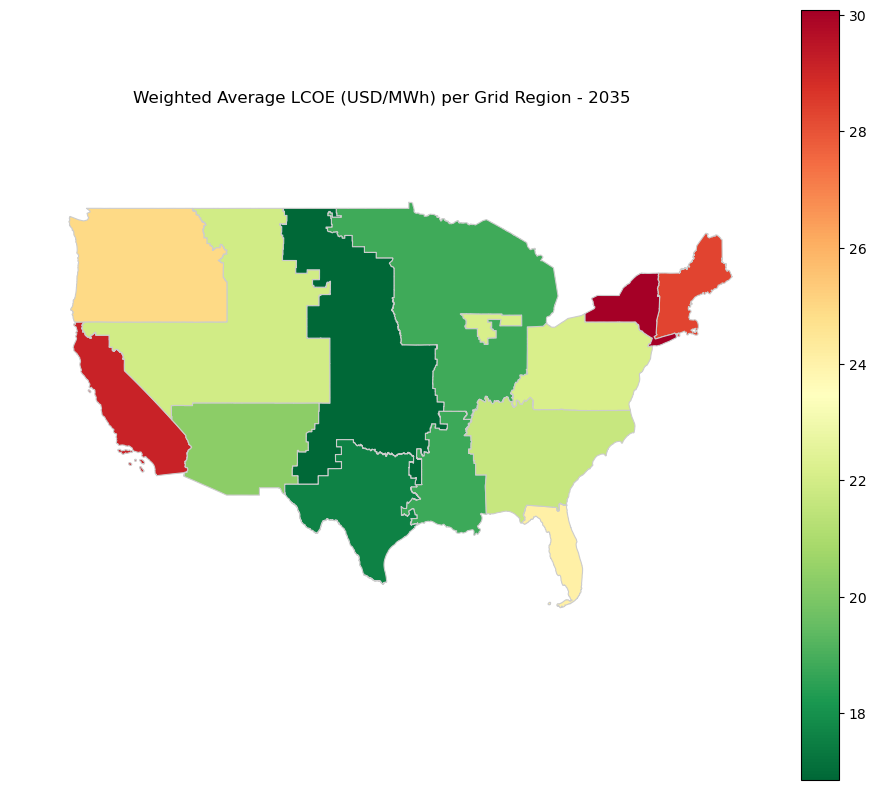

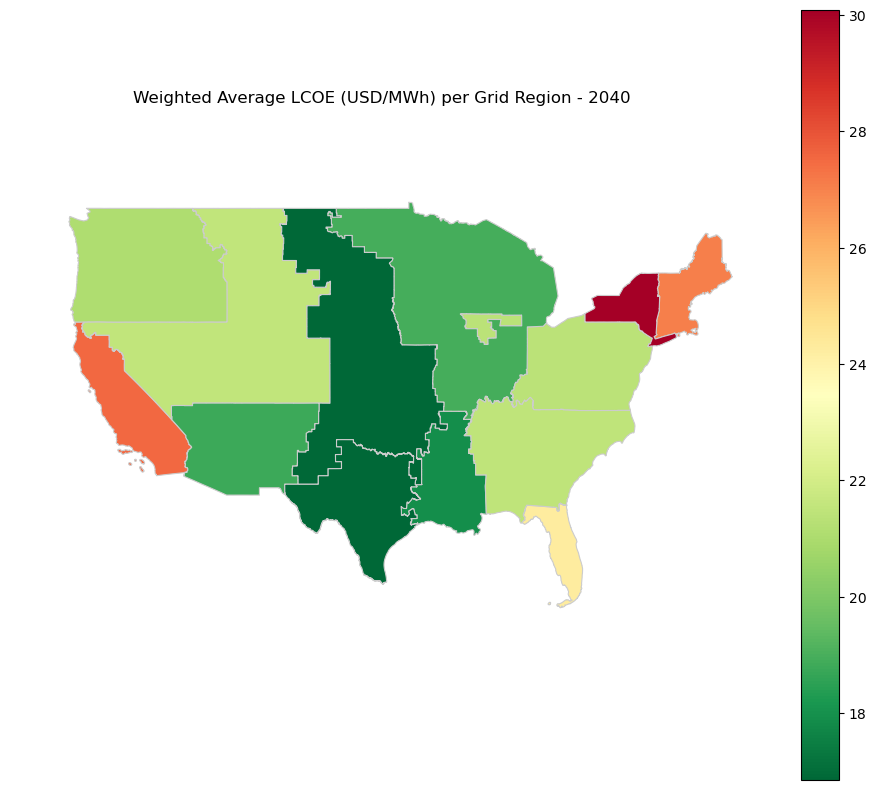

In [35]:
# Step 1: collect LCOE values and cache results
all_weighted_lcoe = []
cached_results = {}

for key, net in networks.items():
    lcoe_gdf, table, lcoe_by_bus, lcoe_data, *_ = calculate_lcoe_summary_and_map(net, shapes)
    cached_results[key] = (net, lcoe_gdf, table, lcoe_by_bus, lcoe_data)

    merged = lcoe_by_bus.merge(lcoe_data[['bus', 'energy']], on='bus', how='left')
    grouped = merged.groupby('grid_region').apply(
        lambda df: (df['weighted_lcoe'] * df['energy']).sum() / df['energy'].sum()
    )
    all_weighted_lcoe.extend(grouped.dropna().values)

# Step 2: compute global vmin/vmax
vmin = np.quantile(all_weighted_lcoe, 0.05)
vmax = np.quantile(all_weighted_lcoe, 0.95)

# Step 3: plot using cached data
plots_data = {}

for key, (net, lcoe_gdf, table, lcoe_by_bus, lcoe_data) in cached_results.items():
    year_match = re.search(r'\d{4}', key)
    year_str = year_match.group() if year_match else "Year N/A"
    title = f"Weighted Average LCOE (USD/MWh) per Grid Region - {year_str}"

    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    plots_data[key] = table

    plot_lcoe_map_by_grid_region(
        lcoe_by_bus, lcoe_data, shapes,
        title=title, key=key, ax=ax,
        vmin=vmin, vmax=vmax
    )

    plt.show()


In [36]:
def uppercase_only_lcoe_word(df):
    new_cols = {
        col: re.sub(r'\blcoe\b', 'LCOE', col, flags=re.IGNORECASE)
        for col in df.columns
    }
    return df.rename(columns=new_cols)

for net_name, table in plots_data.items():
    print(f"\nTable for network: {net_name}")
    display(uppercase_only_lcoe_word(table))


Table for network: Base_2023


grid_region  CCGT LCOE [USD/MWh]  OCGT LCOE [USD/MWh]  \
0         Alaska             12189.01           2938528.83   
1     California                20.51          13274145.58   
2          Delta                18.78           9631664.37   
3        Florida                24.00          20268962.40   
4         Hawaii                  NaN           2917627.27   
5   Mid-Atlantic                24.27          10604732.75   
6        Midwest                20.69           4556182.45   
7       Mountain                18.27           3261089.15   
8    New England                18.22           3677580.31   
9       New York                14.65          20386252.66   
10     Northwest              1592.56           1274499.54   
11        Plains                21.62           5905018.14   
12     Southeast                19.24           8491893.69   
13     Southwest                17.76           5056256.26   
14         Texas                18.71          10948103.07   

    biomass LCOE [USD/MWh]  coal LCOE [USD/MWh]  csp LCOE [USD/MWh]  \
0                     5.01              5569.90         86582916.86   
1                     8.08              2846.41         40152119.39   
2                    14.22               220.45         55154841.88   
3                     5.01             61269.84         28635969.27   
4                    17.33          12181105.88         86510893.63   
5                     7.09              2349.27         35666751.02   
6                     8.98              3147.74         48668820.61   
7                     8.18               383.41         42016897.91   
8                    12.11              2573.90         42668635.14   
9                     6.33                69.20         38453739.66   
10                   11.08              2987.55         42662387.90   
11                    5.01               599.59         40962307.95   
12                   12.79               184.33         37954368.98   
13                    5.66              1764.82         38817950.49   
14                    6.29              1808.86         38557317.65   

    gas LCOE [USD/MWh]  geothermal LCOE [USD/MWh]  hydro LCOE [USD/MWh]  \
0                 8.83                        NaN                 -5.99   
1                 8.83                      53.56                 -5.99   
2                 8.83                        NaN                 -5.99   
3                 8.83                        NaN                   NaN   
4                 8.83                      55.79                   NaN   
5                 8.83                        NaN                 -5.99   
6                 8.83                        NaN                 -5.99   
7                 8.83                      53.56                 -5.99   
8                 8.83                        NaN                 -5.99   
9                 8.83                        NaN                 -5.99   
10                8.83                      53.56                 -5.99   
11                8.83                        NaN                 -5.99   
12                8.83                        NaN                 -5.99   
13                8.83                      53.56                 -5.99   
14                8.83                        NaN                 -5.99   

    nuclear LCOE [USD/MWh]  oil LCOE [USD/MWh]  onwind LCOE [USD/MWh]  \
0                      NaN        7.600000e+00                  68.73   
1                    51.56        1.781433e+07                 140.89   
2                    51.55        7.600000e+00                    NaN   
3                    51.56        6.508099e+07                    NaN   
4                      NaN        8.785000e+01                  52.32   
5                    51.55        1.001820e+08                  67.41   
6                    51.55        3.142641e+06                  49.26   
7                      NaN        2.934000e+01                  54.15   
8                


Table for network: scenario_02_2030


grid_region  CCGT LCOE [USD/MWh]  OCGT LCOE [USD/MWh]  \
0         Alaska                22.15                30.55   
1     California                21.44                25.82   
2          Delta                26.51               194.10   
3        Florida                20.20                86.31   
4         Hawaii                22.72                23.88   
5   Mid-Atlantic                17.90                33.39   
6        Midwest                23.15                43.18   
7       Mountain                40.80                91.48   
8    New England                18.10                38.82   
9       New York                26.19               130.44   
10     Northwest                21.54                26.49   
11        Plains                28.00                65.23   
12     Southeast                18.62                31.15   
13     Southwest                26.00                72.94   
14         Texas                30.01               129.31   

    biomass LCOE [USD/MWh]  coal LCOE [USD/MWh]  csp LCOE [USD/MWh]  \
0                    64.28                  NaN              531.06   
1                    65.32                  NaN              161.08   
2                    67.68                14.71              225.06   
3                    68.27                14.58              214.53   
4                    64.28                  NaN              197.37   
5                    64.91                13.95              259.06   
6                    66.45                16.01              247.07   
7                    65.72                19.97              223.45   
8                    67.03                  NaN              442.34   
9                    64.28                  NaN              284.78   
10                   69.03                16.79              228.27   
11                   65.78                18.04              244.55   
12                   71.03                14.76              246.92   
13                   64.98                16.60              208.55   
14                   65.06                17.12              205.64   

    gas LCOE [USD/MWh]  geothermal LCOE [USD/MWh]  hydro LCOE [USD/MWh]  \
0                16.21                        NaN                  0.01   
1                16.21                      59.67                  0.01   
2                16.21                        NaN                  0.01   
3                16.21                        NaN                   NaN   
4                16.21                      68.05                   NaN   
5                16.21                        NaN                  0.01   
6                16.21                        NaN                  0.01   
7                16.21                      60.76                  0.01   
8                16.21                        NaN                  0.01   
9                16.21                        NaN                  0.01   
10               16.21                      60.35                  0.01   
11               16.21                      67.70                  0.01   
12               16.21                        NaN                  0.01   
13               16.21                      62.63                  0.01   
14               16.21                        NaN                  0.01   

    nuclear LCOE [USD/MWh]  offwind-dc LCOE [USD/MWh]  oil LCOE [USD/MWh]  \
0                      NaN                     246.50                8.26   
1                   190.38                     174.34               51.02   
2                   156.51                     252.79                7.86   
3                   153.40                     266.26               51.01   
4                      NaN                     152.26                9.18   
5                    99.06                     138.51               50.95   
6                   154.23                        NaN               42.89   
7                      NaN                     130.31     


Table for network: scenario_02_2035


grid_region  CCGT LCOE [USD/MWh]  OCGT LCOE [USD/MWh]  \
0         Alaska                23.22                21.62   
1     California                54.06               620.87   
2          Delta                26.72                58.28   
3        Florida                20.88                47.26   
4         Hawaii                23.45                21.54   
5   Mid-Atlantic                19.41                29.48   
6        Midwest                25.14                35.23   
7       Mountain                37.79                62.71   
8    New England                19.01                28.64   
9       New York                24.81                73.02   
10     Northwest                22.51                17.05   
11        Plains                30.56                42.63   
12     Southeast                20.68                32.91   
13     Southwest                23.67                28.74   
14         Texas                32.05                58.71   

    biomass LCOE [USD/MWh]  coal LCOE [USD/MWh]  csp LCOE [USD/MWh]  \
0                    64.29                  NaN              400.15   
1                    65.32                  NaN              159.77   
2                    67.66                15.71              233.02   
3                    68.26                15.39              207.05   
4                    64.28                  NaN              219.71   
5                    64.91                14.17              252.61   
6                    65.47                16.91              248.88   
7                    65.72                20.96              185.87   
8                    67.00                  NaN              327.24   
9                    64.29                  NaN              290.12   
10                   68.57                18.12              206.25   
11                   65.77                19.56              206.49   
12                   70.99                15.51              248.80   
13                   64.98                18.43              167.15   
14                   65.06                18.63              194.70   

    gas LCOE [USD/MWh]  geothermal LCOE [USD/MWh]  hydro LCOE [USD/MWh]  \
0                16.21                        NaN                  0.01   
1                16.21                      64.67                  0.01   
2                16.21                        NaN                  0.01   
3                16.21                        NaN                   NaN   
4                16.21                      77.21                   NaN   
5                16.21                        NaN                  0.01   
6                16.21                        NaN                  0.01   
7                16.21                      66.16                  0.01   
8                16.21                        NaN                  0.01   
9                16.21                        NaN                  0.01   
10               16.21                      66.43                  0.01   
11               16.21                      73.86                  0.01   
12               16.21                        NaN                  0.01   
13               16.21                      68.24                  0.01   
14               16.21                        NaN                  0.01   

    nuclear LCOE [USD/MWh]  offwind-dc LCOE [USD/MWh]  oil LCOE [USD/MWh]  \
0                      NaN                     236.83                8.79   
1                   136.63                     157.72               51.01   
2                   155.96                     244.46                8.24   
3                   121.73                     149.91               50.99   
4                      NaN                     158.45                 NaN   
5                   132.63                     118.83               51.00   
6                   124.70                        NaN               41.84   
7                      NaN                     127.10     


Table for network: scenario_02_2040


grid_region  CCGT LCOE [USD/MWh]  OCGT LCOE [USD/MWh]  \
0         Alaska         2.162000e+01                19.48   
1     California         6.698000e+01               119.64   
2          Delta         2.268000e+01                28.96   
3        Florida         2.017000e+01                27.36   
4         Hawaii         2.386000e+01                22.46   
5   Mid-Atlantic         1.950000e+01                28.57   
6        Midwest         2.868000e+01                30.95   
7       Mountain         3.715000e+01                70.37   
8    New England         1.981000e+01                27.72   
9       New York         5.172650e+08          34946568.47   
10     Northwest         2.738000e+01                19.84   
11        Plains         2.796000e+01                33.13   
12     Southeast         1.985000e+01                28.40   
13     Southwest         2.216000e+01                21.23   
14         Texas         2.674000e+01                30.17   

    biomass LCOE [USD/MWh]  coal LCOE [USD/MWh]  csp LCOE [USD/MWh]  \
0                    64.29                  NaN              308.38   
1                    64.88                  NaN              142.04   
2                    64.29                16.39              209.40   
3                    68.21                  NaN              202.66   
4                    64.28                  NaN              191.52   
5                    64.90                14.26              231.51   
6                    65.46                16.93              216.28   
7                    65.71                33.09              158.67   
8                    66.97                  NaN              318.74   
9                    64.29                  NaN              273.79   
10                   64.77                18.26              177.23   
11                   65.67                20.02              177.91   
12                   70.02                16.00              235.13   
13                   64.28                18.86              144.79   
14                   65.05                19.28              173.27   

    gas LCOE [USD/MWh]  geothermal LCOE [USD/MWh]  hydro LCOE [USD/MWh]  \
0                16.21                        NaN                  0.01   
1                16.21                      66.39                  0.01   
2                16.21                        NaN                  0.01   
3                16.21                        NaN                   NaN   
4                16.21                      76.95                   NaN   
5                16.21                        NaN                  0.01   
6                16.21                        NaN                  0.01   
7                16.21                      67.96                  0.01   
8                16.21                        NaN                  0.01   
9                16.21                        NaN                  0.01   
10               16.21                      66.82                  0.01   
11               16.21                      77.09                  0.01   
12               16.21                        NaN                  0.01   
13               16.21                      71.51                  0.01   
14               16.21                        NaN                  0.01   

    nuclear LCOE [USD/MWh]  offwind-dc LCOE [USD/MWh]  oil LCOE [USD/MWh]  \
0                      NaN                     207.17                 NaN   
1                   133.36                     147.03               51.00   
2                   149.46                     239.30                 NaN   
3                   113.73                     139.45               50.99   
4                      NaN                     145.92                 NaN   
5                   123.91                     113.04               50.95   
6                   119.36                        NaN               11.40   
7                      NaN                     118.74     

### 6.2. Map: Levelized Cost of Hydrogen (LCOH)
*A map displaying the LCOH according to the grid region.*

In [37]:
h2_carriers = [
    "Alkaline electrolyzer large",
    "Alkaline electrolyzer medium",
    "Alkaline electrolyzer small",
    "PEM electrolyzer",
    "SOEC"
]

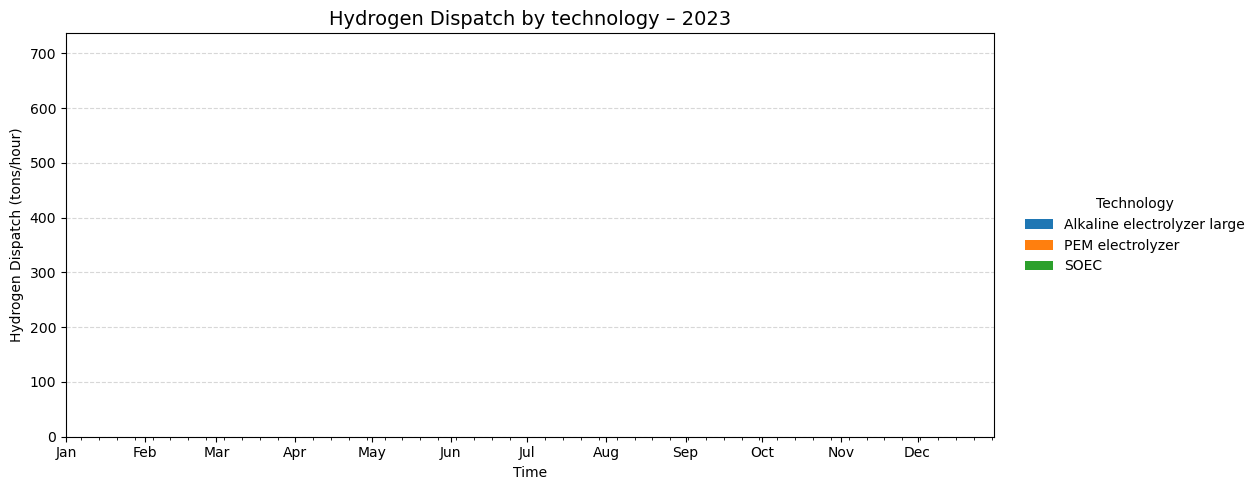

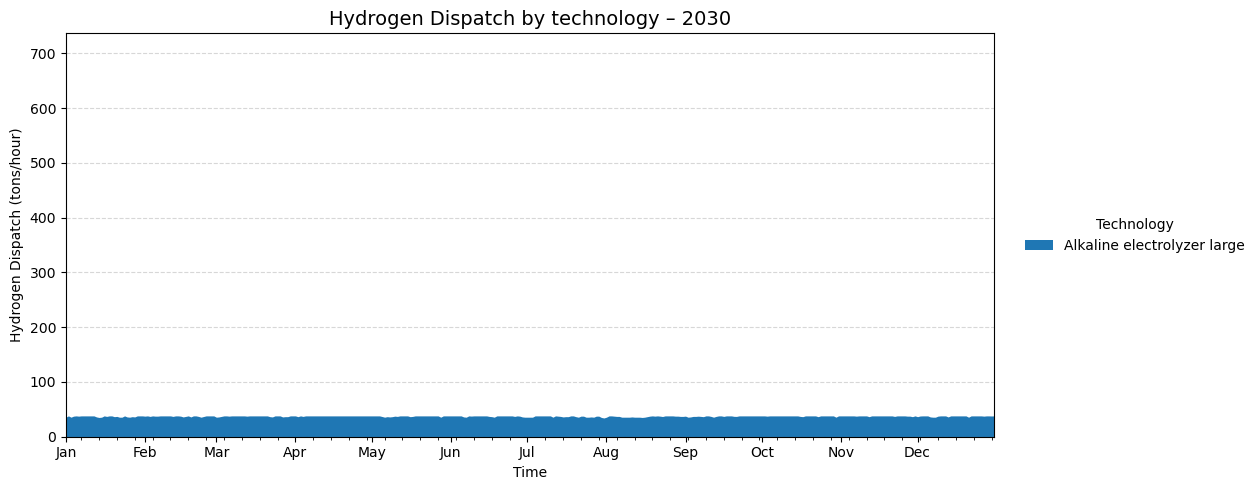

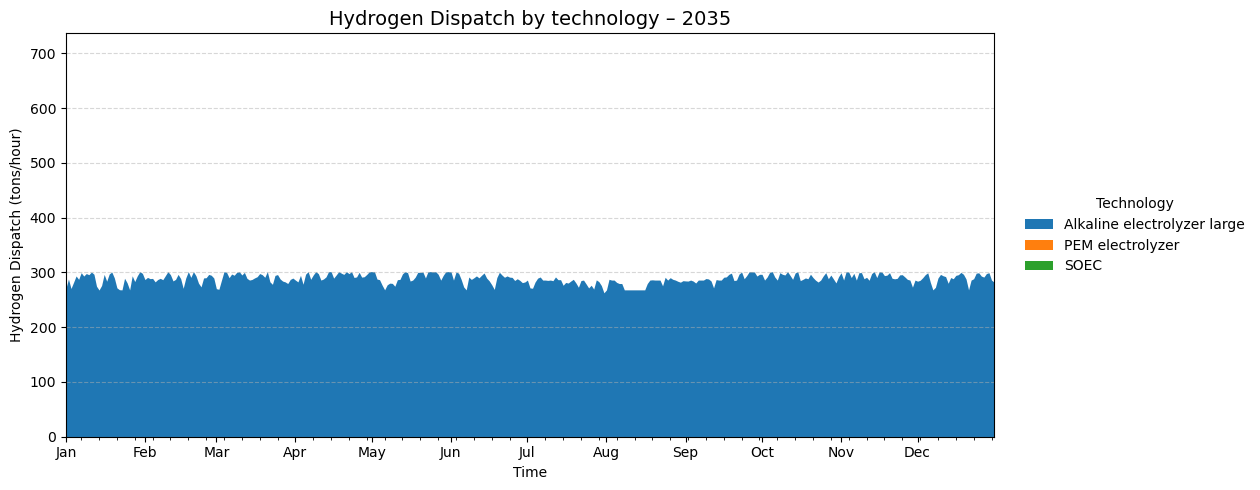

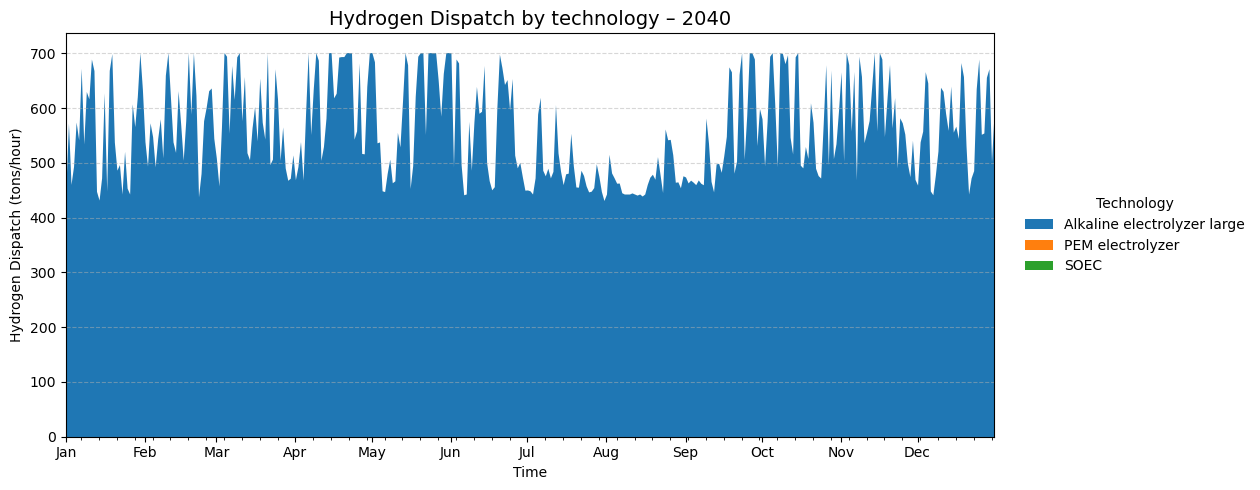

In [38]:
plot_hydrogen_dispatch(networks, h2_carriers)


  No links with H2 output > 100 MWh, skipping.


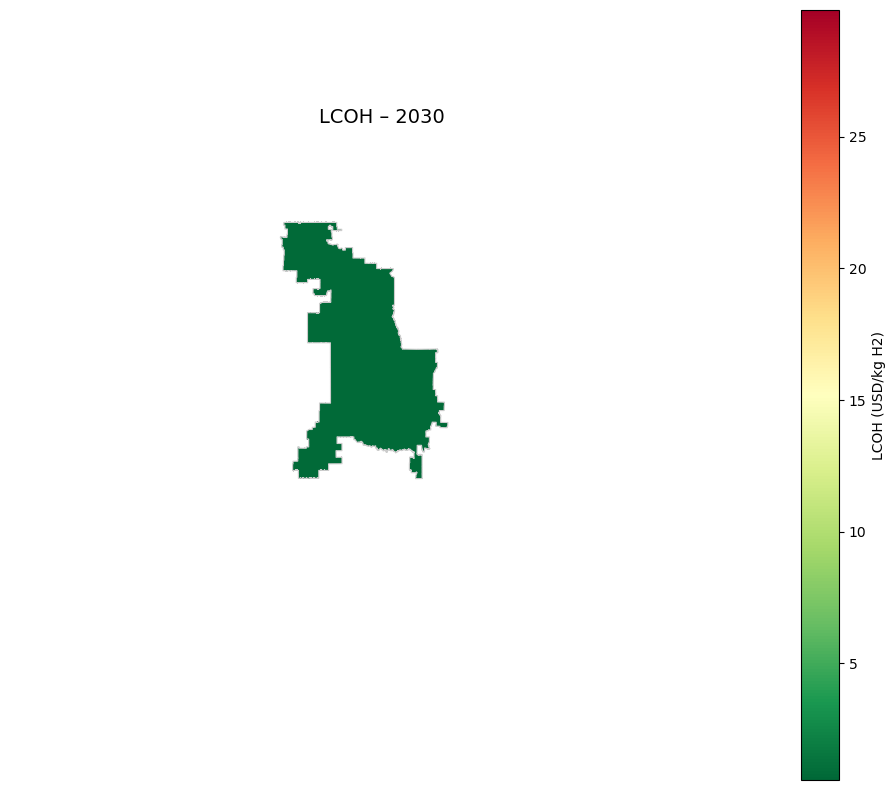

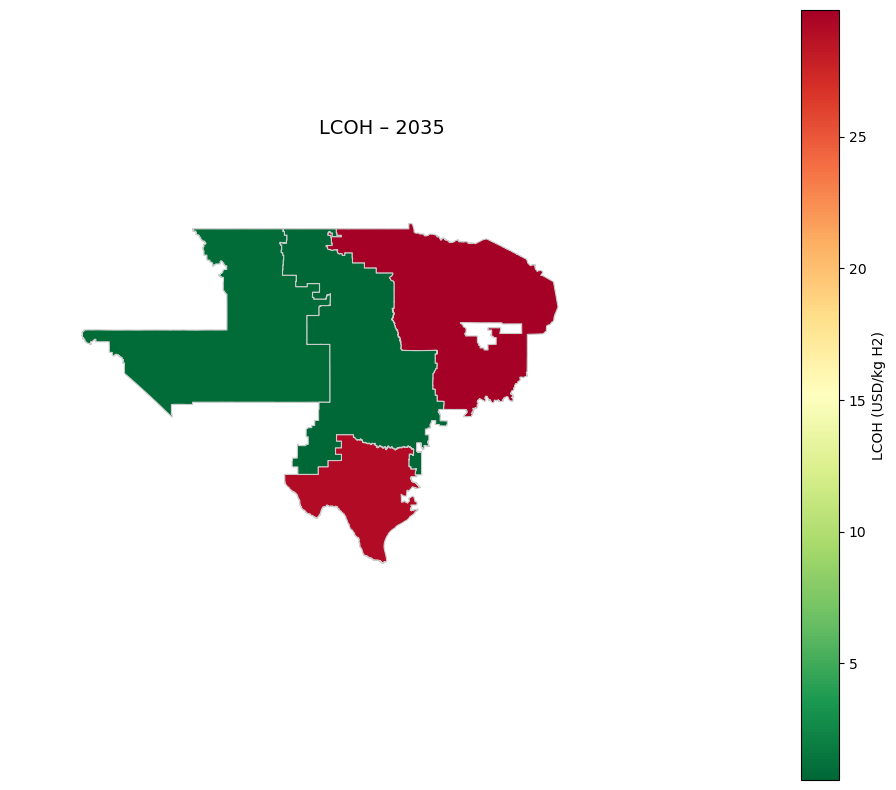

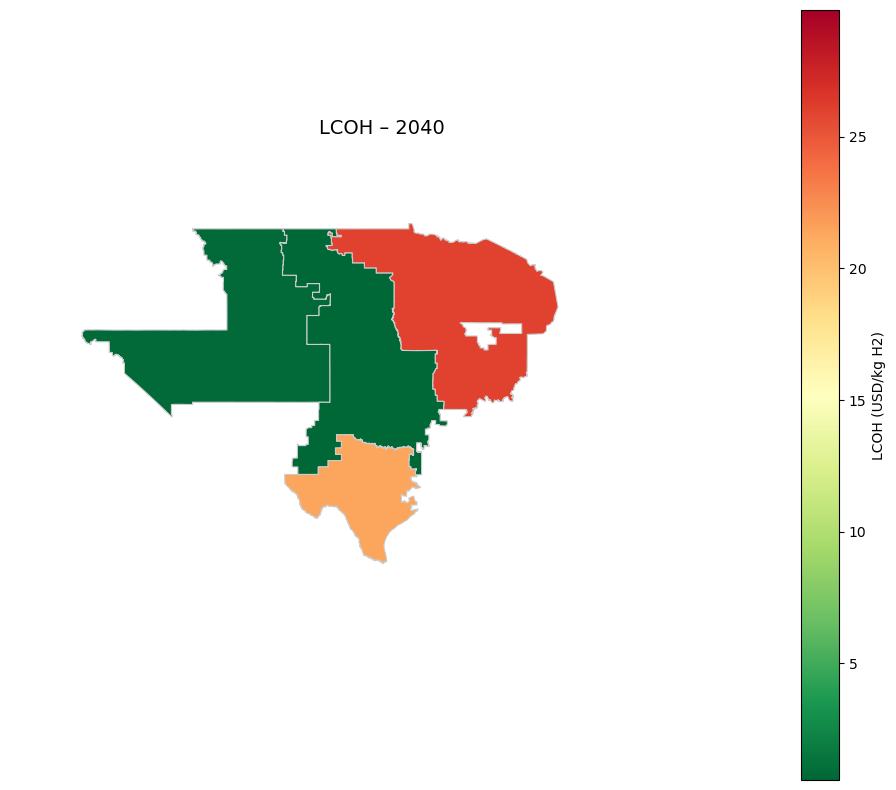

In [39]:
plot_lcoh_maps_by_grid_region(networks, shapes, h2_carriers, output_threshold=100) # Threshodld in MWh/year

In [ ]:
tables_by_year = calculate_weighted_lcoh_table_by_year(networks, h2_carriers, output_threshold=100) # Threshdld in MWh/year

pd.options.display.float_format = '{:,.2f}'.format

for year, table in tables_by_year.items():
    print(f"\n Year: {year} \n")
    display(table)

---

## 7. E-Kerosene

*A dedicated section to analyze e-kerosene production and costs across the US grid regions.*

### 7.1. E-Kerosene Production and Costs

In [ ]:
df = compute_aviation_fuel_demand(networks)

styled_df = (
    df.style
    .hide(axis="index")
    .format({
        "Kerosene (TWh)": "{:,.2f}",
        "e-Kerosene (TWh)": "{:,.2f}",
        "Total (TWh)": "{:,.2f}",
        "e-Kerosene Share (%)": "{:.1f}%",
    })
    .set_caption("Aviation Fuel Demand")
    .set_properties(**{"text-align": "right", "font-size": "12px"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "right"), ("font-size", "12px")]},
        {"selector": "caption", "props": [("caption-side", "top"), ("font-weight", "bold"), ("font-size", "16px")]}
    ])
)

display(styled_df)


In [ ]:
analyze_fischer_tropsch_costs_by_region(networks)

---

# 8. Sector analysis


This section focuses on the role of selected industrial sectors in relation to e-kerosene production (point-source CO2).

In [ ]:
carriers_of_interest = ['NH3', 'ethanol', 'DRI', 'steel BF-BOF', 'steel EAF', 'cement']

In [ ]:
shapes = gpd.read_file(state_shapes_path).to_crs("EPSG:4326")
shapes["state"] = shapes["ISO_1"].str[-2:]  # "US-CA" → "CA"

for key, net in networks.items():

    filtered_loads = net.loads[net.loads["carrier"].isin(carriers_of_interest)].copy()

    filtered_loads["state"] = filtered_loads["bus"].map(net.buses["state"])

    load_by_state = (
        filtered_loads.groupby(["state", "carrier"])["p_set"]
        .sum()
        .mul(8760)  # MW → MWh
        .reset_index()
    )

    present_carriers = load_by_state["carrier"].unique().tolist()
    missing_carriers = [c for c in carriers_of_interest if c not in present_carriers]

    for carrier in missing_carriers:
        load_by_state = pd.concat([
            load_by_state,
            pd.DataFrame({"state": shapes["state"], "carrier": carrier, "p_set": float("nan")})
        ], ignore_index=True)

    load_by_state["carrier"] = pd.Categorical(load_by_state["carrier"], categories=carriers_of_interest, ordered=True)
    load_by_state = load_by_state.sort_values("carrier")

    n_carriers = len(carriers_of_interest)
    n_cols = 2
    n_rows = (n_carriers + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 5))
    axes = axes.flatten()

    for i, carrier in enumerate(carriers_of_interest):
        carrier_data = load_by_state[load_by_state["carrier"] == carrier].copy()
        map_df = shapes.merge(carrier_data, on="state", how="left")

        ax = axes[i]
        map_df.plot(
            column="p_set",
            ax=ax,
            legend=True,
            cmap="OrRd",
            missing_kwds={"color": "lightgrey", "label": "No data"},
            edgecolor="black"
        )
        ax.set_title(f"{carrier}", fontsize=12)
        ax.set_xlim([-180, -65])
        ax.set_ylim([15,75])
        ax.axis('off')

        leg = ax.get_legend()
        if leg:
            leg.set_bbox_to_anchor((1, 0.5))
            for t in leg.get_texts():
                t.set_fontsize(8)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    key
    fig.suptitle(f"Total electric load by State [MWh] - {key}", fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()